# 경희대학교 우울증 게시판 패턴 분석 및 우울증 관리 방안 도출

<div style="text-align: right"> 2020105729 임성은 </div>

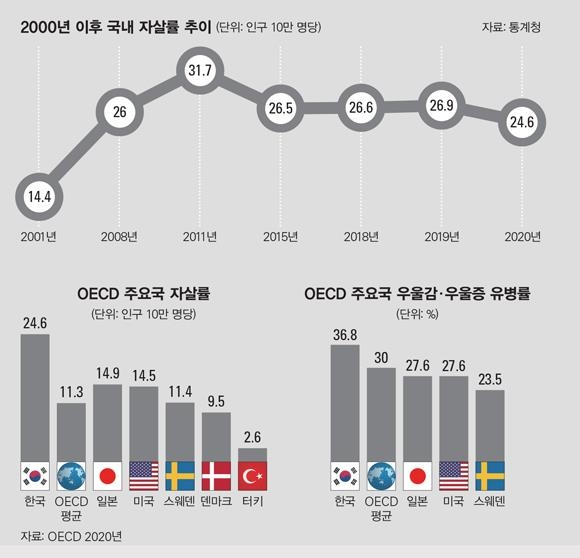

한국의 자살률과 우울증 유병률이 높다는 사실은 이미 잘 알려져 있다. 통계청 자료에 따르면, 2000년 이후 국내 자살률은 꾸준히 증가하여 2011년 31.7명(인구 10만 명당)을 기록하였고, 최근 통계인 2022년에도 25.2명으로 다소 감소했으나 여전히 높은 수준을 유지하고 있다.<br>
<br>
또한, OECD 주요국 중에서도 한국의 자살률은 가장 높은 24.6명으로 나타나고 있다. OECD 주요국 우울감·우울증 유병률에서도 한국은 36.8%로 가장 높은 수치를 기록하고 있다. 이는 OECD 평균인 30%를 크게 웃도는 수치이다. 이러한 높은 자살률과 우울증 유병률은 한국 사회의 중요한 문제임을 나타낸다.

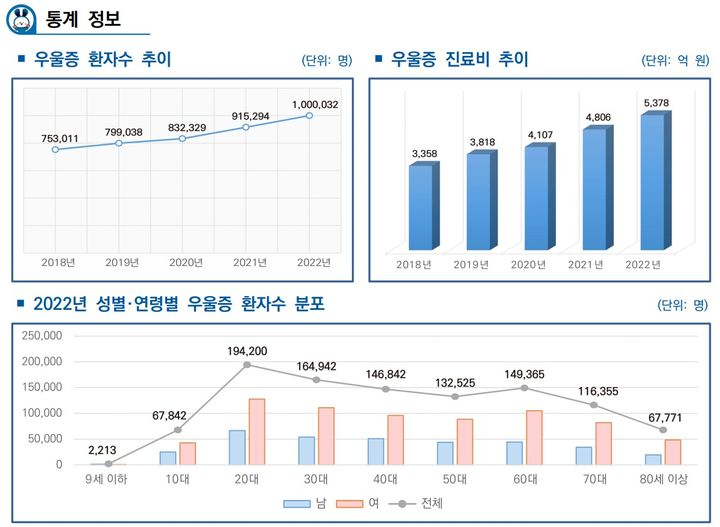

건강보험심사평가원의 '생활 속 질병·진료행위 통계'에 따르면, 연간 우울증으로 진료를 받은 환자 수는 100만 명을 넘어섰고, 연 평균 7.4%씩 증가하고 있다. 특히 2030대 우울증 환자는 2018년 26%에서 2022년 36%로 증가했으며, 20대 환자는 약 20%인 194,200명에 달한다. 이는 20대의 우울증이 사회적으로 큰 문제로 대두되고 있음을 보여준다.

이에 따라, 경희대학교 에브리타임의 우울증 게시판 글들을 크롤링하여 우리 학교 내에서 가장 대두되는 주제와 시간대 별 게시판 활성도 등을 파악하고, 여러 인사이트를 도출하려고 한다. 분석 결과를 바탕으로 다양한 활용 방안을 제시할 것이다.

먼저 데이터를 가져올 게시판에 대해 설명하겠다.

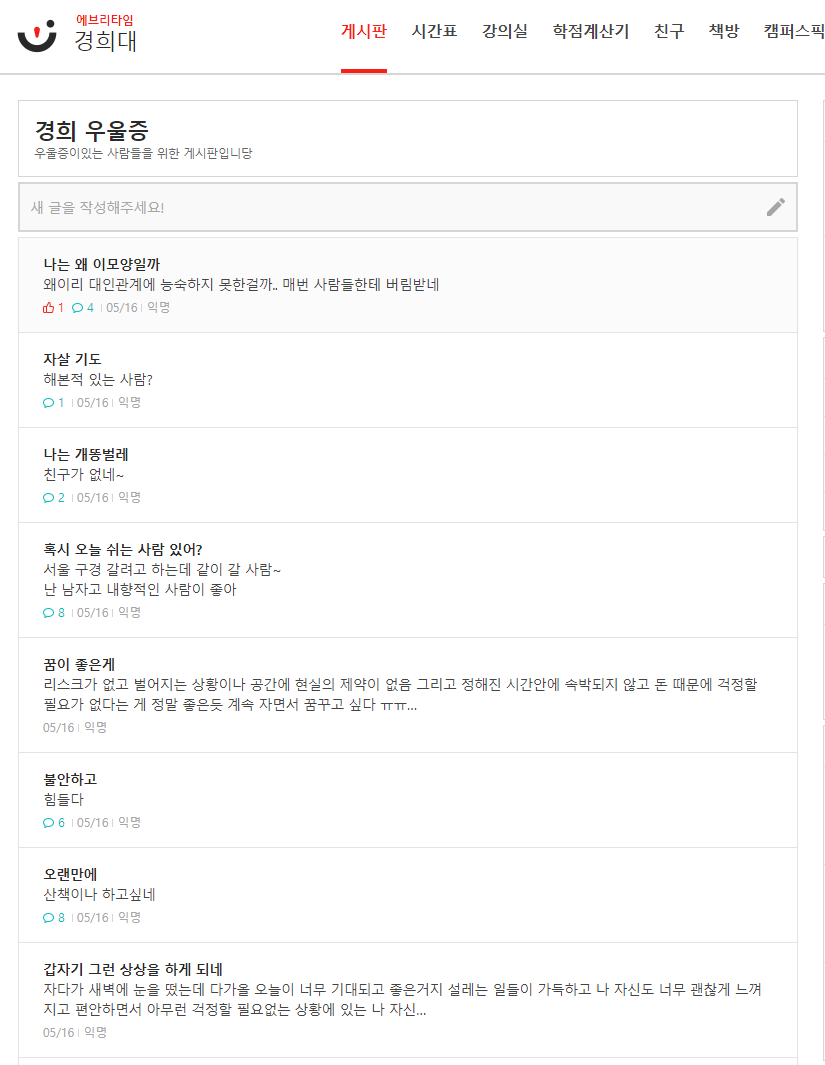

에브리타임은 국내 최대 대학생활 플랫폼이다. 자유게시판, 장터게시판, 홍보게시판 등 여러 게시판이 있어 다양한 정보를 공유하고 소통할 수 있다. 또한, 에브리타임은 익명 게시판 기능을 제공하여 학생들이 보다 자유롭게 자신의 고민이나 의견을 표현할 수 있다.

그 중 경희대학교 우울증 게시판은 17년도 12월 16일 첫 글이 올라왔으며, 2023년 기준 하루 평균 약 4.4개의 글이 올라오는 게시판이다.<br>
2018년의 게시글 수는 다른 년도들에 비해 글의 개수가 현저히 작아 크롤링에서 제외했다.

먼저 게시판의 제목, 내용, 날짜, 좋아요 수, 댓글 수, 스크랩 수를 크롤링해오겠다. 밑은 그 과정이다.

In [1]:
!pip install selenium

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time
import openpyxl
webdriver_options = webdriver.ChromeOptions()
webdriver_options.add_argument('--headless')
webdriver_options.add_argument('--no-sandbox')
webdriver_options.add_argument('--disable-dev-shm-usage')
webdriver_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36')
# 크롬 드라이버 위치를 넣으면 된다.
driver = webdriver.Chrome('C:/Users/82106/chromedriver/chromedriver-win64/chromedriver-win64/chromedriver')
driver.implicitly_wait(3)

In [4]:
driver.get("https://everytime.kr/login") # 접속 주소
driver.implicitly_wait(10)
driver.find_element(By.NAME, 'id').send_keys('nihao0108') # 아이디
driver.find_element(By.NAME, 'password').send_keys('PASSWORD') # 비밀번호
driver.find_element(By.XPATH, '/html/body/div[1]/div/form/input').click() # 로그인 버튼
driver.find_element(By.XPATH, '//*[@id="submenu"]/div/div[14]/ul/li[5]/a').click() # 경희우울증

경희대학교 게시판은 경희대학교 학생만 접근할 수 있기에 에브리타임 접속 주소에 자신의 아이디와 비밀번호만 입력하면 경희대학교 에브리타임으로 접속할 수 있다.

In [2]:
import pandas as pd

In [6]:
from time import sleep
import random
from selenium.common.exceptions import NoSuchElementException
results = []
batch_size = 30  # 한 번에 저장할 페이지 수
batch_counter = 1  # 배치 카운터
post_id = 1

cnt = 329  # 시작 페이지 설정
max_cnt = 329  # 마지막 페이지 설정

try:
    while cnt <= max_cnt:
        print('Page ' + str(cnt))

        driver.get('https://everytime.kr/386930/p/' + str(cnt))
        driver.implicitly_wait(50)

        posts = driver.find_elements_by_css_selector('article.list')
        links = [post.find_element_by_css_selector('a.article').get_attribute('href') for post in posts]
        print(f'Found {len(links)} posts on page {cnt}')

        for link in links:
            try:
                driver.get(link)
                sleep(random.uniform(1, 7))  # 1초에서 7초 사이의 랜덤한 대기 시간
                
                post_title = driver.find_element_by_css_selector('h2.large').text
                post_content = driver.find_element_by_css_selector('p.large').text
                post_time = driver.find_element_by_css_selector('time.large').text
                like_comment = driver.find_element_by_css_selector('ul.status.left').text

                results.append({
                    'Post ID': post_id,
                    'Post Title': post_title,
                    'Post Content': post_content,
                    'Post Time': post_time,
                    'Links': link,
                    'Likes, Comments, Scrap': like_comment
                })
                post_id += 1
                
            except NoSuchElementException as e:
                print(f"Error occurred while processing link: {link}. Error: {e}")
                results.append({
                    'Post ID': post_id,
                    'Post Title': '',
                    'Post Content': '',
                    'Post Time': '',
                    'Links': link,
                    'Likes, Comments, Scrap': 'Error'
                })

        if cnt % batch_size == 0:
            # 30페이지마다 데이터 저장
            df = pd.DataFrame(results)
            df.to_excel(f'everytime_posts_batch_{batch_counter}.xlsx', index=False)
            print(f"Batch {batch_counter} saved.")
            batch_counter += 1
            results = []  # 결과 초기화

        cnt += 1

    # 남은 결과 저장
    if results:
        df = pd.DataFrame(results)
        df.to_excel(f'everytime_posts_batch_{batch_counter}.xlsx', index=False)
        print(f"Final batch {batch_counter} saved.")

except Exception as e:
    print(f"An error occurred: {e}")
    # 크롤링 중 오류가 발생한 경우 지금까지의 결과를 저장
    if results:
        df = pd.DataFrame(results)
        df.to_excel(f'everytime_posts_error_2_batch_{batch_counter}.xlsx', index=False)
        print(f"Error batch {batch_counter} saved.")

finally:
    # 드라이버 종료
    driver.quit()
    print("크롤링 끝")


Page 329
Found 20 posts on page 329
Final batch 1 saved.
크롤링 끝


30 페이지에 한 번씩 batch로 저장하게 하였으며<br>
이후 Colab에서 해당 batch 엑셀들을 하나의 엑셀로 합쳤다.
밑의 두 코드는 batch 엑셀들을 합치고, LIkes, Comments, Scrap열로 분리하고, Post TIme 열을 Year, Month, Day, Hour, Minute 열로 나누는 코드이다.

In [ ]:
file_paths = [
    'everytime_posts_batch_1.xlsx', #합칠 엑셀들
]
combined_data = pd.concat([pd.read_excel(file) for file in file_paths])

combined_data[['Likes', 'Comments', 'Scrap']] = combined_data['Likes, Comments, Scrap'].str.split(expand=True)

combined_data['Likes'] = pd.to_numeric(combined_data['Likes'], errors='coerce')
combined_data['Comments'] = pd.to_numeric(combined_data['Comments'], errors='coerce')
combined_data['Scrap'] = pd.to_numeric(combined_data['Scrap'], errors='coerce')

combined_data['Post Time'] = pd.to_datetime(combined_data['Post Time'], format='%y/%m/%d %H:%M', errors='coerce')

combined_data['Year'] = combined_data['Post Time'].dt.year % 100  # Two-digit year
combined_data['Month'] = combined_data['Post Time'].dt.month
combined_data['Day'] = combined_data['Post Time'].dt.day
combined_data['Hour'] = combined_data['Post Time'].dt.hour
combined_data['Minute'] = combined_data['Post Time'].dt.minute

output_file_path = 'everytime_posts_final_ff.xlsx'
combined_data.to_excel(output_file_path, index=False)

print(f"Processed data saved to {output_file_path}")

In [ ]:
# post time 열 기준으로 정렬하고 post id 1부터 시작하도록 변경하는 코드
# 파일 경로 목록을 지정합니다.
file_paths = [
    'path_to_your_file/everytime_posts_2024.01.01_to_today.xlsx',
    'path_to_your_file/everytime_posts_2020.xlsx',
    'path_to_your_file/everytime_posts_2021.xlsx',
    'path_to_your_file/everytime_posts_2022.xlsx',
    'path_to_your_file/everytime_posts_2023.xlsx'
]

sorted_file_paths = []

for file_path in file_paths:
    df = pd.read_excel(file_path)
    
    df_sorted = df.sort_values(by='Post Time')
    
    df_sorted['Post ID'] = range(1, len(df_sorted) + 1)
    
    sorted_file_path = file_path.replace('.xlsx', '_sorted.xlsx')
    df_sorted.to_excel(sorted_file_path, index=False)
    sorted_file_paths.append(sorted_file_path)

for path in sorted_file_paths:
    print(path)

모든 코롤링 과정이 끝났다.

데이터 EDA를 진행해보겠다. 데이터를 이해하고, 여러 관련도를 확인해볼 것이다.

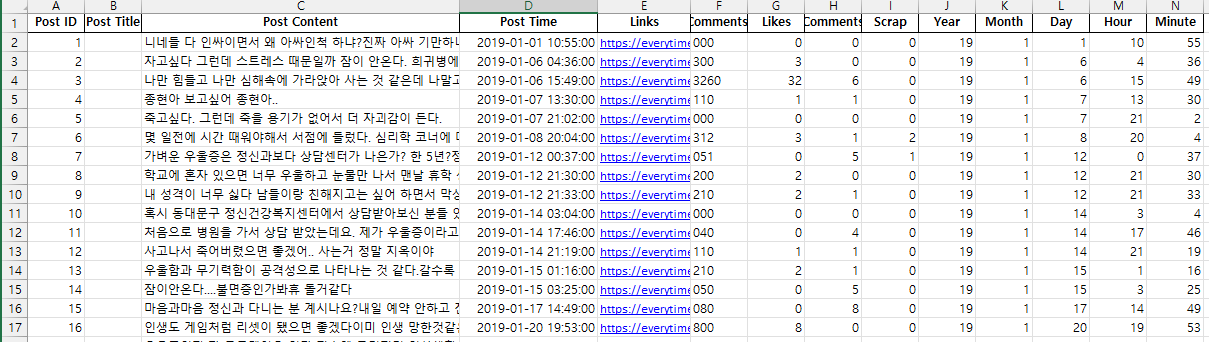

엑셀에 저장된 데이터 일부이다.<br><br>
2023년 이전엔 제목을 작성하는 기능이 없었기에 Post 내용과, 시간, 링크, 좋아요 댓글 스크랩 수(크롤링 시에 따로 나눌 수 없었기에 크롤링 이후 나누었다), 좋아요 수, 댓글 수, 스크랩 수, 포스팅 년, 월, 일, 시, 분으로 나누었다.<br>

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Post ID                 6568 non-null   int64         
 1   Post Title              1641 non-null   object        
 2   Post Content            6567 non-null   object        
 3   Post Time               6082 non-null   datetime64[ns]
 4   Links                   6568 non-null   object        
 5   Likes, Comments, Scrap  6568 non-null   object        
 6   Likes                   6568 non-null   int64         
 7   Comments                6568 non-null   int64         
 8   Scrap                   6568 non-null   int64         
 9   Year                    6082 non-null   float64       
 10  Month                   6082 non-null   float64       
 11  Day                     6082 non-null   float64       
 12  Hour                    6082 non-null   float64 

총 크롤링한 게시글의 개수는 6568개이다.<br>
2024년의 데이터는 아직까지 활발히 올라오고 있고, 1년치 데이터가 쌓이지 않아, 따로 게시글 시간을 크롤링해오지 않았다.<br>
그렇기에 Post Time이 들어간 행은 6082개이다.

In [10]:
combined_df.describe()

Post ID        Likes     Comments        Scrap         Year  \
count  6568.000000  6568.000000  6568.000000  6568.000000  6082.000000   
mean   3284.500000     0.840895     1.898752     0.144032  2021.260605   
std    1896.162616     3.256572     3.238870     1.072075     1.369310   
min       1.000000     0.000000     0.000000     0.000000  2019.000000   
25%    1642.750000     0.000000     0.000000     0.000000  2020.000000   
50%    3284.500000     0.000000     1.000000     0.000000  2021.000000   
75%    4926.250000     1.000000     2.000000     0.000000  2023.000000   
max    6568.000000   136.000000    83.000000    35.000000  2023.000000   

             Month          Day         Hour       Minute  
count  6082.000000  6082.000000  6082.000000  6082.000000  
mean      6.755179    15.479612    12.855968    29.651430  
std       3.333427     8.729862     8.174324    17.087012  
min       1.000000     1.000000     0.000000     0.000000  
25%       4.000000     8.000000     3.000000    15.000000  
50%       7.000000    15.000000    15.000000    30.000000  
75%      10.000000    23.000000    20.000000    44.000000  
max      12.000000    31.000000    23.000000    59.000000

결측치와 Anomaly는 없었으며, Outlier가 좋아요, Comments 등에서 보이긴 했지만 의미 있는 데이터라 판단하여 그냥 두었다.<br>
제일 좋아요가 높은 게시글과 댓글 수가 높은 게시물을 확인해보자.

In [12]:
most_liked_post = combined_df.loc[combined_df['Likes'].idxmax()]
most_comment_post = combined_df.loc[combined_df['Comments'].idxmax()]

most_liked_post_link = most_liked_post['Links']
most_comment_post_link = most_comment_post['Links']

most_liked_post_link
most_comment_post_link

'https://everytime.kr/386930/v/307670392'

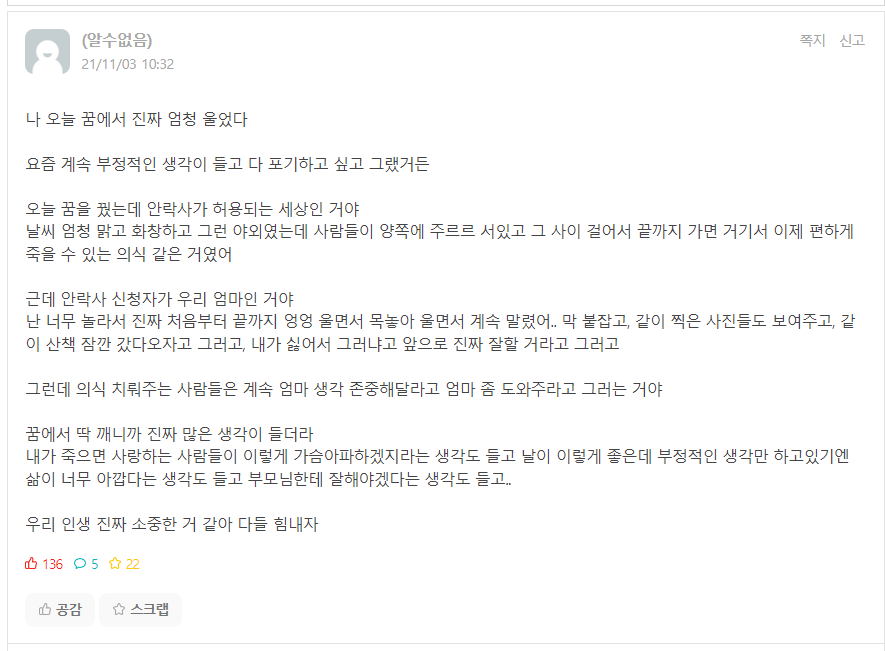

좋아요가 가장 높은 게시글이다.

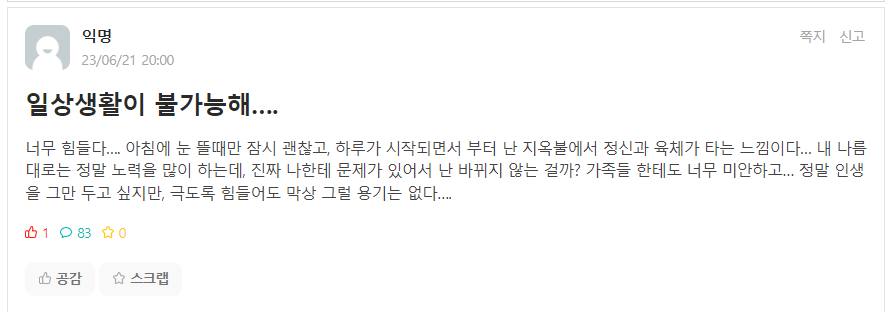

댓글 수가 가장 높은 게시글이다.<br><br>
두 게시물의 내용이 전혀 다른 것이 흥미롭다.

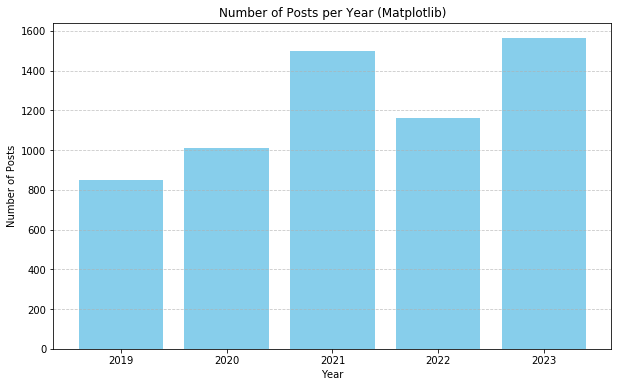

In [4]:
import matplotlib.pyplot as plt
combined_file_path = 'C:/Users/82106/Desktop/3-1/응데분/Project_data/everytime_posts_combined_sorted.xlsx'
combined_df = pd.read_excel(combined_file_path)

combined_df['Year'] = pd.DatetimeIndex(combined_df['Post Time']).year

post_counts_per_year = combined_df['Year'].value_counts().sort_index()

# Plot using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(post_counts_per_year.index, post_counts_per_year.values, color='skyblue')
plt.title('Number of Posts per Year (Matplotlib)')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

년도별 게시글의 개수를 분석해보았다. 통계에서 보았듯이, 2019년부터 2023년까지 우울증 유병률이 증가한 것처럼, 대체로 2023년까지 게시글의 수가 증가하고 있다.

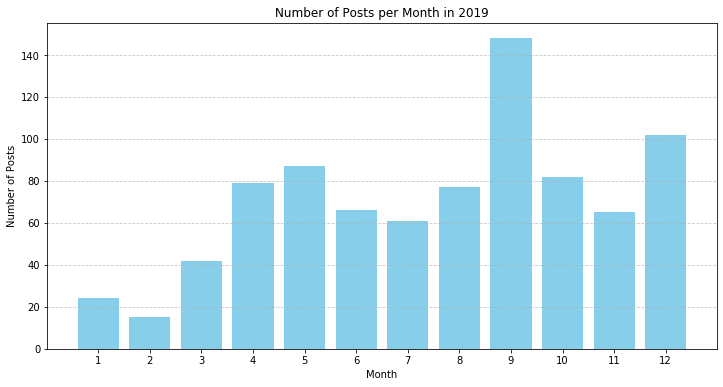

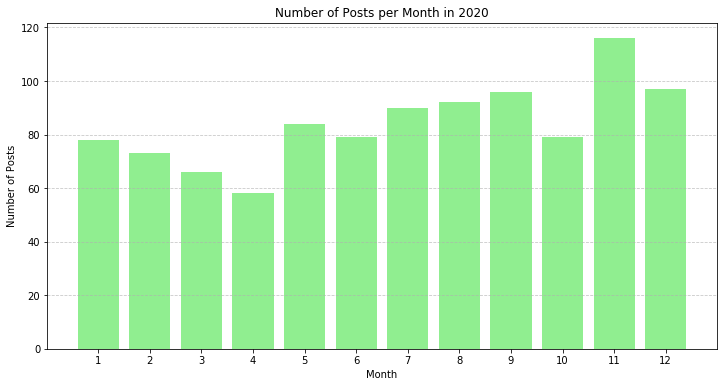

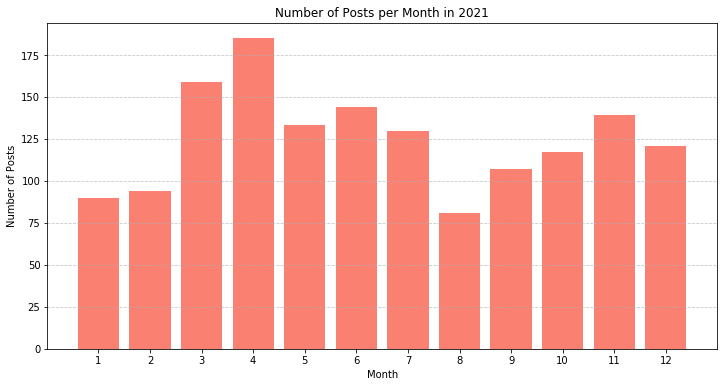

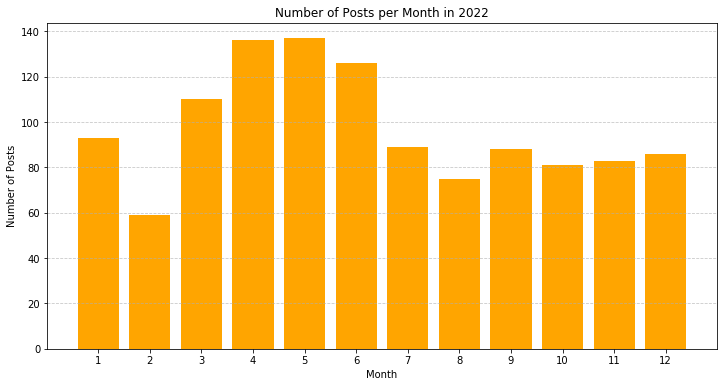

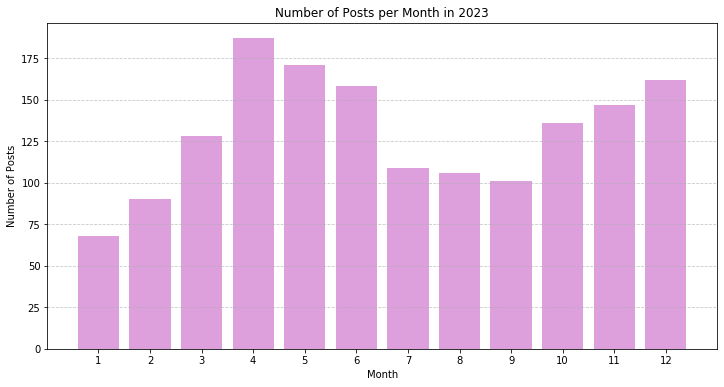

In [6]:
import pandas as pd

combined_df['Year'] = pd.DatetimeIndex(combined_df['Post Time']).year
combined_df['Month'] = pd.DatetimeIndex(combined_df['Post Time']).month

data_2019 = combined_df[combined_df['Year'] == 2019]
data_2020 = combined_df[combined_df['Year'] == 2020]
data_2021 = combined_df[combined_df['Year'] == 2021]
data_2022 = combined_df[combined_df['Year'] == 2022]
data_2023 = combined_df[combined_df['Year'] == 2023]

monthly_counts_2019 = data_2019.groupby('Month').size()
monthly_counts_2020 = data_2020.groupby('Month').size()
monthly_counts_2021 = data_2021.groupby('Month').size()
monthly_counts_2022 = data_2022.groupby('Month').size()
monthly_counts_2023 = data_2023.groupby('Month').size()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts_2019.index, monthly_counts_2019.values, color='skyblue')
plt.title('Number of Posts per Month in 2019')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(monthly_counts_2019.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts_2020.index, monthly_counts_2020.values, color='lightgreen')
plt.title('Number of Posts per Month in 2020')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(monthly_counts_2020.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts_2021.index, monthly_counts_2021.values, color='salmon')
plt.title('Number of Posts per Month in 2021')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(monthly_counts_2021.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts_2022.index, monthly_counts_2022.values, color='orange')
plt.title('Number of Posts per Month in 2022')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(monthly_counts_2022.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(monthly_counts_2023.index, monthly_counts_2023.values, color='plum')
plt.title('Number of Posts per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(monthly_counts_2023.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

게시글을 년도별로 나눈 이후, x를 월별로 게시글의 수를 y로 두어 그래프를 그려보았다. 3, 4, 5월에 교내 학생들이 게시글을 많이 쓴다는 사실을 파악할 수 있다.<br>
#### 하지만 이상한 점이 있다. 2019년 9월이 비정상적으로 게시글 수가 많음을 볼 수 있다.

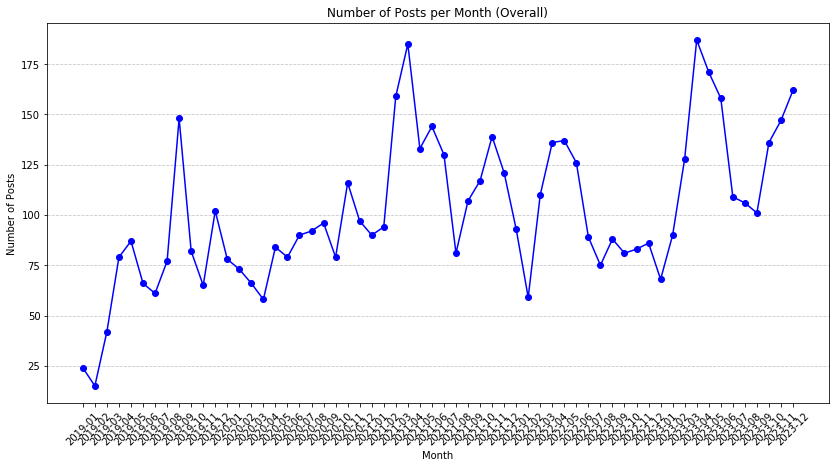

In [15]:
# 연도와 월 추출
combined_df['YearMonth'] = pd.to_datetime(combined_df['Post Time']).dt.to_period('M')

# 월별 게시글 수 계산
monthly_counts = combined_df['YearMonth'].value_counts().sort_index()

# 전체 데이터의 월별 게시글 수 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_counts.index.astype(str), monthly_counts.values, marker='o', linestyle='-', color='b')
plt.title('Number of Posts per Month (Overall)')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 전체 데이터의 월별 게시글을 시각화 하여도, 2019년의 다른 월별 게시글 수에 비해, 2019년 9월은 눈에 띄게 높다.

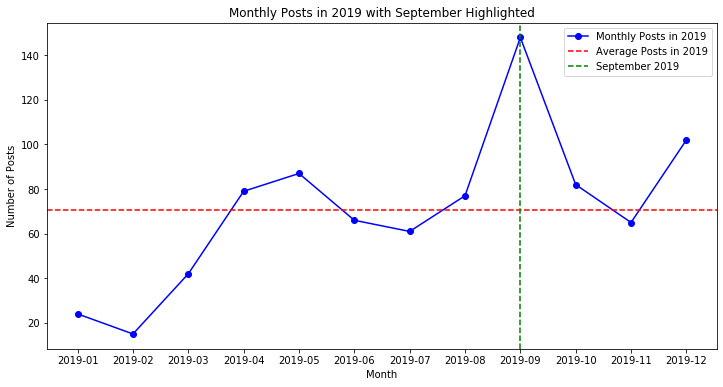

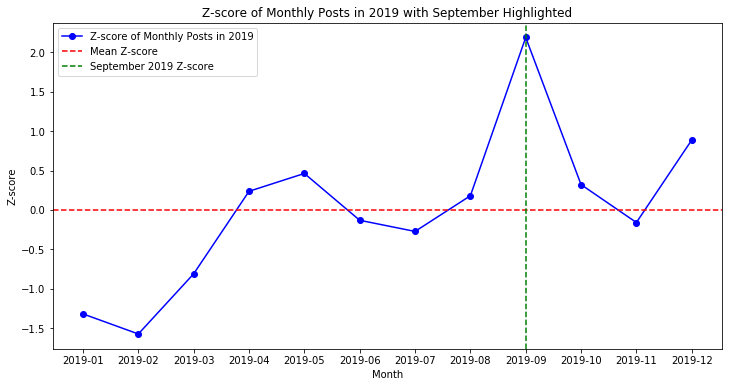

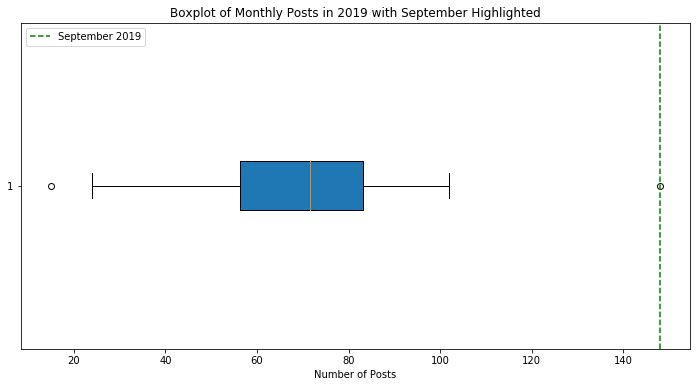

(70.66666666666667, 2.1902924855631323, 27.0)

In [18]:
posts_2019 = posts_per_month[posts_per_month.index.year == 2019]
average_posts_2019 = posts_2019.mean()

z_scores_2019 = (posts_2019 - average_posts_2019) / posts_2019.std()

q1_2019 = posts_2019.quantile(0.25)
q3_2019 = posts_2019.quantile(0.75)
iqr_2019 = q3_2019 - q1_2019

plt.figure(figsize=(12, 6))
plt.plot(posts_2019.index.astype(str), posts_2019.values, marker='o', linestyle='-', color='b', label='Monthly Posts in 2019')
plt.axhline(y=average_posts_2019, color='r', linestyle='--', label='Average Posts in 2019')
plt.axvline(x='2019-09', color='g', linestyle='--', label='September 2019')
plt.title('Monthly Posts in 2019 with September Highlighted')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(posts_2019.index.astype(str), z_scores_2019.values, marker='o', linestyle='-', color='b', label='Z-score of Monthly Posts in 2019')
plt.axhline(y=0, color='r', linestyle='--', label='Mean Z-score')
plt.axvline(x='2019-09', color='g', linestyle='--', label='September 2019 Z-score')
plt.title('Z-score of Monthly Posts in 2019 with September Highlighted')
plt.xlabel('Month')
plt.ylabel('Z-score')
plt.legend()

plt.figure(figsize=(12, 6))
plt.boxplot(posts_2019.values, vert=False, patch_artist=True)
plt.axvline(x=posts_september_2019, color='g', linestyle='--', label='September 2019')
plt.title('Boxplot of Monthly Posts in 2019 with September Highlighted')
plt.xlabel('Number of Posts')
plt.legend()

plt.show()

average_posts_2019, z_scores_2019['2019-09'], iqr_2019


##### 2019년 9월 게시글의 수는 148개였다. 2019년 평균 게시글 수가 70개이며, Z-score 갚이 2가 넘으니 이는 Outlier로 판단할 수 있겠다.

그럼 왜 Outlier가 된 걸까? 다른 이유가 있을까?

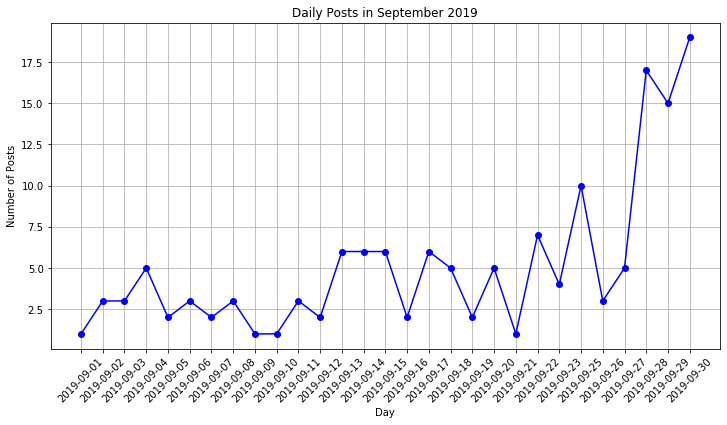

In [21]:
df_september_2019 = combined_df[(combined_df['Post Time'].dt.year == 2019) & (combined_df['Post Time'].dt.month == 9)]

posts_per_day_september_2019 = df_september_2019['Post Time'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(posts_per_day_september_2019.index.astype(str), posts_per_day_september_2019.values, marker='o', linestyle='-', color='b')
plt.title('Daily Posts in September 2019')
plt.xlabel('Day')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### 유난히 9월28, 29, 30일의 게시글 수가 높았다. 이는 눈으로만 봐도 바로 이상치임을 확인할 수 있다. 왜 이런 현상이 일어났을까?

In [23]:
mean_september_2019 = posts_per_day_september_2019.mean()
std_september_2019 = posts_per_day_september_2019.std()
z_scores_september_2019 = (posts_per_day_september_2019 - mean_september_2019) / std_september_2019

outliers = z_scores_september_2019.loc[[pd.Timestamp('2019-09-28'), pd.Timestamp('2019-09-29'), pd.Timestamp('2019-09-30')]]

outliers

2019-09-28    2.555741
2019-09-29    2.126080
2019-09-30    2.985402
Name: Post Time, dtype: float64

( Z-score를 통해 보아도 28 29 30일 모두 이상치이다.)

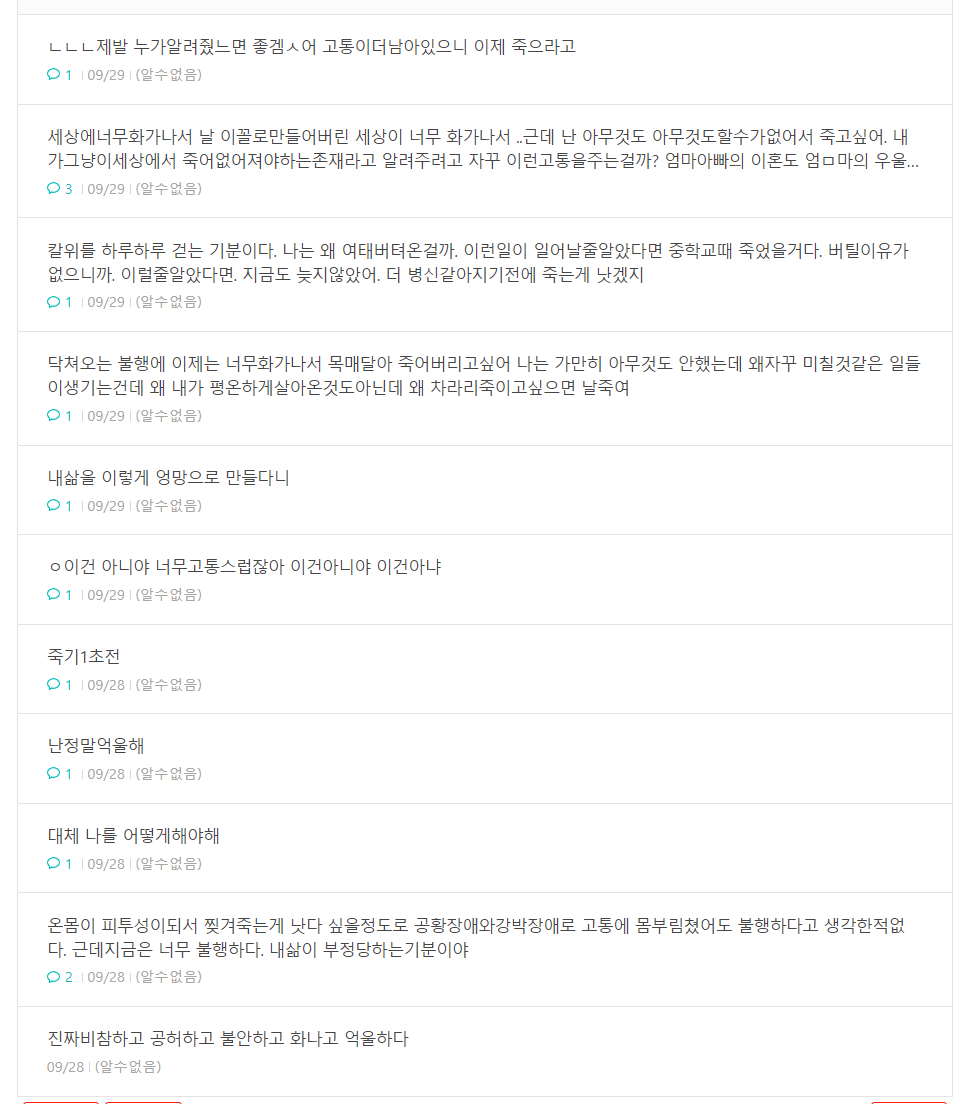

#### 모든 글이 익명으로 올라오는 게시판이라 확실하진 않지만, 
#### 글이 올라오는 시간대가 비슷하고, 글의 내용과 문체를 보아 모두 같은 사람이 쓴 게시판임을 예상할 수 있었다. 

우리는 일반적으로 4월에 게시글의 수가 높음을 알 수 있었다.

## 가설 1 : 1년 중 봄에 게시글의 활발도가 가장 높을 것이다.

> 여기서 활발도란, 좋아요 수, 댓글 수, 스크랩 수를 모두 합친 것을 의미한다. 특정 시기에 게시글의 수가 증가하는 것처럼, 사람들의 참여도가 높은 시기, 시간대를 판단할 수 있을 것이라 생각한다.<br>
이를 T-Test로 검증할 것이다.

3, 4, 5월(봄)의 데이터 중 랜덤하게 30개의 게시글을 들고 온다.<br>
7, 8, 9월(여름)의 데이터 중 랜덤하게 30개의 게시글을 들고 온다.<br>
T test를 통해 '두 집단의 게시글 활발도가 같은가?'를 파악할 것이다.<br>


> **귀무가설**
>> 봄(3, 4, 5월)과 여름(7, 8, 9월) 두 집단의 게시글 활발도(평균 게시글 수)가 같다.

> **대립가설**
>> 봄(3, 4, 5월)과 여름(7, 8, 9월) 두 집단의 게시글 활발도(평균 게시글 수)가 다르다.

In [24]:
from scipy.stats import ttest_ind

file_path = 'C:/Users/82106/Desktop/3-1/응데분/Project_data/everytime_posts_combined_sorted.xlsx'
data = pd.read_excel(file_path)

spring_data = data[data['Month'].isin([3, 4, 5])]
summer_data = data[data['Month'].isin([7, 8, 9])]

spring_sample = spring_data.sample(n=30, random_state=42)
summer_sample = summer_data.sample(n=30, random_state=42)

spring_sample['Engagement'] = spring_sample[['Likes', 'Comments', 'Scrap']].sum(axis=1)
summer_sample['Engagement'] = summer_sample[['Likes', 'Comments', 'Scrap']].sum(axis=1)

t_test_result = ttest_ind(spring_sample['Engagement'], summer_sample['Engagement'], equal_var=True)

t_test_result

print(spring_sample[['Likes', 'Comments', 'Scrap', 'Engagement']].describe())
print(summer_sample[['Likes', 'Comments', 'Scrap', 'Engagement']].describe())


           Likes  Comments      Scrap  Engagement
count  30.000000  30.00000  30.000000   30.000000
mean    0.666667   2.70000   0.100000    3.466667
std     1.124441   3.74304   0.402578    3.857222
min     0.000000   0.00000   0.000000    0.000000
25%     0.000000   0.00000   0.000000    1.000000
50%     0.000000   1.00000   0.000000    2.500000
75%     1.000000   4.75000   0.000000    5.000000
max     4.000000  18.00000   2.000000   18.000000
           Likes   Comments  Scrap  Engagement
count  30.000000  30.000000   30.0   30.000000
mean    0.466667   1.266667    0.0    1.733333
std     0.819307   2.049951    0.0    2.288402
min     0.000000   0.000000    0.0    0.000000
25%     0.000000   0.000000    0.0    0.000000
50%     0.000000   0.000000    0.0    1.000000
75%     1.000000   1.750000    0.0    3.500000
max     3.000000   7.000000    0.0    7.000000


In [25]:
t_test_result

Ttest_indResult(statistic=2.116817017532287, pvalue=0.038576173549237994)

Ttest_indResult(statistic=2.116817017532287, pvalue=0.038576173549237994)


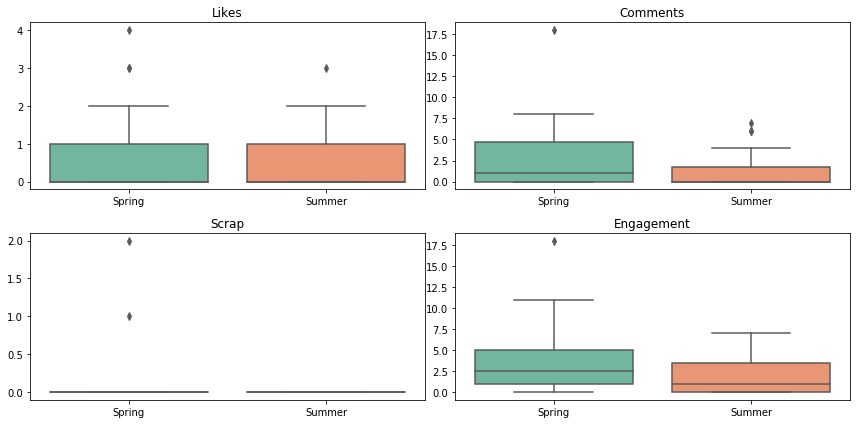

In [26]:
import seaborn as sns
from scipy.stats import ttest_ind

spring_data = data[data['Month'].isin([3, 4, 5])]
summer_data = data[data['Month'].isin([7, 8, 9])]

spring_sample = spring_data.sample(n=30, random_state=42)
summer_sample = summer_data.sample(n=30, random_state=42)

spring_sample['Engagement'] = spring_sample[['Likes', 'Comments', 'Scrap']].sum(axis=1)
summer_sample['Engagement'] = summer_sample[['Likes', 'Comments', 'Scrap']].sum(axis=1)

t_test_result = ttest_ind(spring_sample['Engagement'], summer_sample['Engagement'], equal_var=True)

print(t_test_result)

spring_desc = spring_sample[['Likes', 'Comments', 'Scrap', 'Engagement']].describe()
summer_desc = summer_sample[['Likes', 'Comments', 'Scrap', 'Engagement']].describe()

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.boxplot(data=[spring_sample['Likes'], summer_sample['Likes']], palette="Set2")
plt.xticks([0, 1], ['Spring', 'Summer'])
plt.title('Likes')

plt.subplot(2, 2, 2)
sns.boxplot(data=[spring_sample['Comments'], summer_sample['Comments']], palette="Set2")
plt.xticks([0, 1], ['Spring', 'Summer'])
plt.title('Comments')

plt.subplot(2, 2, 3)
sns.boxplot(data=[spring_sample['Scrap'], summer_sample['Scrap']], palette="Set2")
plt.xticks([0, 1], ['Spring', 'Summer'])
plt.title('Scrap')

plt.subplot(2, 2, 4)
sns.boxplot(data=[spring_sample['Engagement'], summer_sample['Engagement']], palette="Set2")
plt.xticks([0, 1], ['Spring', 'Summer'])
plt.title('Engagement')

plt.tight_layout()
plt.show()


#### p-value가 0.05인 유의 수준보다 작기 때문에 우린 귀무 가설을 기각할 수 있다.

#### p-value가 0.05보다 작기 때문에, 봄과 여름의 게시글 활발도가 통계적으로 유의미하게 다르다고 결론지을 수 있다. 이는 두 시기 동안 게시글의 평균 개수가 다름을 시사한다.

#### 즉 1년 중 봄에 게시글 활발도가 가장 높을 것이라는 나의 가설이 성립한다.

이 결과는 봄과 여름의 게시글 활발도가 같지 않다는 것을 나타내며, 계절에 따라 게시글 활동에 차이가 있음을 의미한다.

## 가설 2 : 우울증 게시판은 주로 취업, 학점에 관련된 내용일 것이다.

> 특정 주제에 관련된 게시글들을 군집시키면, 우울증 게시판에서 자주 나타나는 주제를 파악할 수 있을 것이다. 대학생들의 주된 고민인 취업과, 학점에 관련된 주제들이 군집되지 않을까?<br>
게시판 글 내용을 Text Analysis를 통해 토큰화하고, 이를 Clustering한다.

konlpy를 설치하기 위해서는 복잡한 환경 설정 과정을 거쳐야한다.

In [5]:
conda update conda

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [6]:
conda --version

conda 4.14.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install "jpype1==1.2.0"

  Using cached JPype1-1.2.0-cp37-cp37m-win_amd64.whl (1.6 MB)
  Attempting uninstall: jpype1
    Found existing installation: jpype1 0.7.5
    Uninstalling jpype1-0.7.5:
      Successfully uninstalled jpype1-0.7.5
Note: you may need to restart the kernel to use updated packages.


계속해서 Exception has occurred: SystemError
java.nio.file.InvalidPathException: Illegal char <*> <br>
오류가 뜨는 걸 jpype1 버전 오류라는 걸 알고 해결했다

* conda update는 kernel restart 만으로 안된다 .. jupyter 자체를 재시작하자 ..

In [2]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


모든 준비가 완료되었다.<br>
수업 시간에 배운 Text Analysis 과정을 그대로 따라해보자.

In [29]:
from konlpy.tag import Okt
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_colwidth', None)
file_path = 'C:/Users/82106/Desktop/3-1/응데분/Project_data/everytime_posts_combined_sorted.xlsx'
df = pd.read_excel(file_path)
df['combined_text'] = df[['Post Title', 'Post Content']].fillna('').agg(' '.join, axis=1)
df

Post ID                Post Title  \
0           1                       NaN   
1           2                       NaN   
2           3                       NaN   
3           4                       NaN   
4           5                       NaN   
...       ...                       ...   
6563     6564                    우울의 감정   
6564     6565              새해 첫날부터 우울..   
6565     6566                 꿈 속에 있을때가   
6566     6567  오늘이 마지막날이라고 작년 첫날에 다짐했는데   
6567     6568                  나이만 먹는구나   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Post Content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 니네들 다 인싸이면서 왜 아싸인척 하냐?\n진짜 아싸 기만하니까 좋냐?   
1     자고싶다 그런데 스트레스 때문일까 잠이 안온다. 희귀병에 걸렸다 군대에서 손이 아침에 안굽혀지길래 병원가서 진찰받고 상담하다가 희귀병이라고 들었다 그 병과 관련되어 추가 진찰을 하다보니 희귀병이 1개 더 발견되었다 또 다른 거는 의증이라는데 이것도 너무 증상이 나타나서 위험하다고 한다\n병원에서 장이 불안해서 스테로이드제를 복용하자고 했다 염증을 완화해주는 약들은 다 쌔게 한 상황이다 당분간 없나했는데 근데 그저께 아침에 입술에 노랗게 염증차오른 얼굴을 보고 절망했다 스테로이드제를 복용하면 우울증이 올 수도 있다고 한다 우울증인지 불안인지 잘때마다 죽으면 어쩌지 내가보는 시야가 마지막 시야면 어쩌지 눈을 잃고 다음날 난 어떻게 연락을 해서 날 도와달라고 하지 하는 생각에 빠진다\n국군수도병원에서 신체검사를 다시해서 5급판정을 받았다 2주만에 받아낸거같은데 엄청 빠르게 나왔다고한다 상황이 심각한가보다 나는 그냥 그런데 주위 의사들은 난리다\n복학을 해야할거같다 지금 당장 내가 죽어도 그 이유가 있는 상태지만 아무렇지않게 그냥 평범히 살고 있는 척이라도 하고싶다\n자고싶다 어쩌다가 이리된걸까 다음주에 만나기로 한 날짜보다 빨리 병원에 가봐야겠다 염증이 다시 났고 잠을 잘 수가 없다   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              나만 힘들고 나만 심해속에 가라앉아 사는 것 같은데 나말고도 이런 애들이 많구나... 힘내자 얘들아...   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          종현아 보고싶어 종현아..   
4                                                                                                                                                                                                                                                                                                                                                                                               

In [30]:
# Remove unwanted characters and convert to lowercase
df['combined_text'] = df['combined_text'].str.strip(' .!~')
df['combined_text'] = df['combined_text'].str.lower()

# Initialize Okt
okt = Okt()

게시글을 전처리하고 토큰화한다.

In [31]:
# Tokenize
df['tokens'] = df['combined_text'].apply(lambda comment: okt.pos(comment, norm=True, stem=True))
df['tokens']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

한국어 자연어처리의 문제점으로 '아싸'가 감탄사로 나온다..

In [32]:
def get_only_noun_adjective_list(sentence):
    noun_adjective = []
    for word, pos in okt.pos(sentence, norm=True, stem=True):
        if pos in ('Noun', 'Adjective'):
            noun_adjective.append(word)
    return noun_adjective

df['tokens'] = df['combined_text'].apply(lambda x: get_only_noun_adjective_list(x))
df['tokens']

0                                                                                                                                                                                                                                                                                                                                                                                                [네, 인, 왜, 인척, 진짜, 기만, 좋다]
1       [스트레스, 때문, 잠, 희귀, 병, 군대, 손, 아침, 병원, 진찰, 상담, 희귀, 병, 그, 병과, 관련, 추가, 진찰, 희귀, 병, 개, 더, 발견, 또, 다른, 거, 의증, 데, 것, 증상, 위험하다, 병원, 불안하다, 스테로이드, 제, 복용, 염증, 완화, 약, 쌔, 상황, 당분간, 없다, 그저께, 아침, 입술, 노랗다, 염증, 얼굴, 보고, 절망, 스테로이드, 제, 복용, 우울증, 수도, 있다, 우울증, 불안, 때, 가보, 시야, 마지막, 시야, 눈, 다음, 날, 난, 어떻다, 연락, 날, 도, 달라, 생각, 국군, 수도, 병원, 신체검사, 다시, 급, 판정, 주, 같다, 빠르다, 상황, 심각하다, 나, 그냥, 주위, 의사, 난리, 복학, 같다, 지금, 당장, 내, 그, 이유, 있다, 상태, ...]
2                                                                                                                                                                                 

주제 분석을 위해 토큰들 중 명사와 형용사만 남겼다.

In [33]:
# Function to remove stopwords
def removing_stopwords(words):
    stopwords = {'이다', '있다'}
    return [word for word in words if len(word) > 1 and word not in stopwords]

df['tokens'] = df['tokens'].apply(lambda x: removing_stopwords(x))
df[['combined_text','tokens']].head()

combined_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              니네들 다 인싸이면서 왜 아싸인척 하냐?\n진짜 아싸 기만하니까 좋냐?   
1  자고싶다 그런데 스트레스 때문일까 잠이 안온다. 희귀병에 걸렸다 군대에서 손이 아침에 안굽혀지길래 병원가서 진찰받고 상담하다가 희귀병이라고 들었다 그 병과 관련되어 추가 진찰을 하다보니 희귀병이 1개 더 발견되었다 또 다른 거는 의증이라는데 이것도 너무 증상이 나타나서 위험하다고 한다\n병원에서 장이 불안해서 스테로이드제를 복용하자고 했다 염증을 완화해주는 약들은 다 쌔게 한 상황이다 당분간 없나했는데 근데 그저께 아침에 입술에 노랗게 염증차오른 얼굴을 보고 절망했다 스테로이드제를 복용하면 우울증이 올 수도 있다고 한다 우울증인지 불안인지 잘때마다 죽으면 어쩌지 내가보는 시야가 마지막 시야면 어쩌지 눈을 잃고 다음날 난 어떻게 연락을 해서 날 도와달라고 하지 하는 생각에 빠진다\n국군수도병원에서 신체검사를 다시해서 5급판정을 받았다 2주만에 받아낸거같은데 엄청 빠르게 나왔다고한다 상황이 심각한가보다 나는 그냥 그런데 주위 의사들은 난리다\n복학을 해야할거같다 지금 당장 내가 죽어도 그 이유가 있는 상태지만 아무렇지않게 그냥 평범히 살고 있는 척이라도 하고싶다\n자고싶다 어쩌다가 이리된걸까 다음주에 만나기로 한 날짜보다 빨리 병원에 가봐야겠다 염증이 다시 났고 잠을 잘 수가 없다   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              나만 힘들고 나만 심해속에 가라앉아 사는 것 같은데 나말고도 이런 애들이 많구나... 힘내자 얘들아   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         종현아 보고싶어 종현아   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       죽고싶다. 그런데 죽을 용기가 없어서 더 자괴감이 든다   

                                                                                                                                                                                                                                                                                                                                                                    tokens  
0                                                                                                                                                                                                                                                                                                                                                         [인척, 진짜, 기만, 좋다]  
1  [스트레스, 때문, 희귀, 군대, 아침, 병원, 진찰, 상담, 희귀, 병과, 관련, 추가, 진찰, 희귀, 발견, 다른, 의증, 증상, 위험하다, 병원, 불안하다, 스테로이드, 복용, 염증, 완화, 상황, 당분간, 없다, 그저께, 아침, 입술, 노랗다, 염증, 얼굴, 보고, 절망, 스테

df을 확인해보니, '없다', '같다', '많다' 와 같은 adj도 우리가 원하는 "특정 주제"에는 맞지 않다고 판단하여 오로지 명사만 남기기로 했다.

In [34]:
# 명사만 추출하는 함수 정의
def get_only_noun_list(sentence):
    nouns = []
    for word, pos in okt.pos(sentence, norm=True, stem=True):
        if pos == 'Noun':
            nouns.append(word)
    return nouns

df['tokens'] = df['combined_text'].apply(lambda x: get_only_noun_list(x))

# 불용어 제거 함수 정의
def removing_stopwords(words):
    stopwords = {'이다', '있다'}
    return [word for word in words if len(word) > 1 and word not in stopwords]

df['tokens'] = df['tokens'].apply(lambda x: removing_stopwords(x))
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
df[['processed_text','tokens']].head()

processed_text  \
0                                                                                                                                                                                                                             인척 진짜 기만   
1  스트레스 때문 희귀 군대 아침 병원 진찰 상담 희귀 병과 관련 추가 진찰 희귀 발견 다른 의증 증상 병원 스테로이드 복용 염증 완화 상황 당분간 그저께 아침 입술 염증 얼굴 보고 절망 스테로이드 복용 우울증 수도 우울증 불안 가보 시야 마지막 시야 다음 연락 달라 생각 국군 수도 병원 신체검사 다시 판정 상황 그냥 주위 의사 난리 복학 지금 당장 이유 상태 그냥 어쩌다가 다음주 날짜 병원 염증 다시 수가   
2                                                                                                                                                                                                                                   심해   
3                                                                                                                                                                                                                                종현 종현   
4                                                                                                                                                                                                                                용기 자괴   

                                                                                                                                                                                                                                                                                                       tokens  
0                                                                                                                                                                                                                                                                                                [인척, 진짜, 기만]  
1  [스트레스, 때문, 희귀, 군대, 아침, 병원, 진찰, 상담, 희귀, 병과, 관련, 추가, 진찰, 희귀, 발견, 다른, 의증, 증상, 병원, 스테로이드, 복용, 염증, 완화, 상황, 당분간, 그저께, 아침, 입술, 염증, 얼굴, 보고, 절망, 스테로이드, 복용, 우울증, 수도, 우울증, 불안, 가보, 시야, 마지막, 시야, 다음, 연락, 달라, 생각, 국군, 수도, 병원, 신체검사, 다시, 판정, 상황, 그냥, 주위, 의사, 난리, 복학, 지금, 당장, 이유, 상태, 그냥, 어쩌다가, 다음주, 날짜, 병원, 염증, 다시, 수가]  
2                                                                                                                                                                                                                                                                                                        [심해]  
3                                                                                                                                                                                                                                                                                                    [종현, 종현]  
4                                                                                                                                                                                                                                                                                                    [용기, 자괴]

#### 단순하게 전체 데이터 단어의 빈도를 한 번 보자
모든 게시글의 토근화된 명사들의 개수를 count해서 어떤 단어가 가장 많이 나왔는지 파악해보자.

['NanumGothic']
Word Frequencies 2019
  Word  Count  Year
0   사람    242  2019
1   생각    218  2019
2  우울증    142  2019
3   고통    119  2019
4   그냥    111  2019
5   진짜     91  2019
6   정말     85  2019
7   엄마     81  2019
8   자살     75  2019
9   인생     70  2019

Word Frequencies 2020
  Word  Count  Year
0   사람    306  2020
1   생각    301  2020
2   그냥    209  2020
3  우울증    189  2020
4   진짜    123  2020
5   친구     98  2020
6   마음     98  2020
7   병원     96  2020
8   엄마     94  2020
9   지금     93  2020

Word Frequencies 2021
  Word  Count  Year
0   사람    429  2021
1   생각    364  2021
2   그냥    286  2021
3  우울증    215  2021
4   정신    162  2021
5   진짜    158  2021
6   친구    140  2021
7   오늘    138  2021
8   병원    129  2021
9   마음    122  2021

Word Frequencies 2022
  Word  Count  Year
0   사람    292  2022
1   생각    263  2022
2   그냥    250  2022
3   진짜    155  2022
4  우울증    135  2022
5   상담    107  2022
6   친구    100  2022
7   지금     91  2022
8   마음     88  2022
9   오늘     85  2022

Word Frequen

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


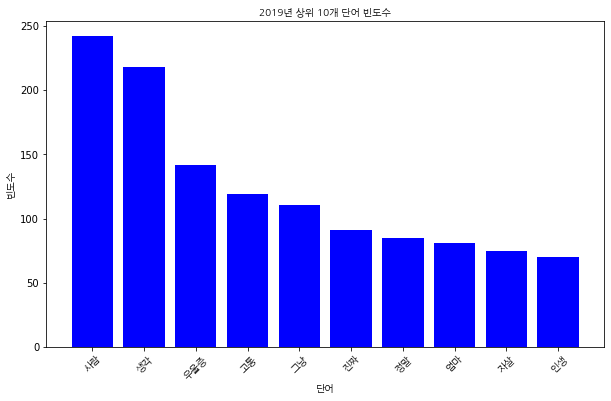

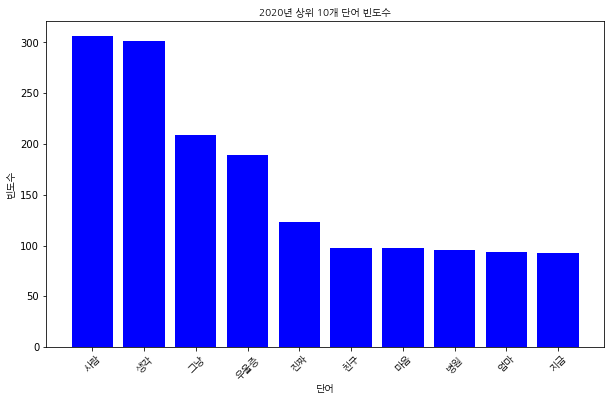

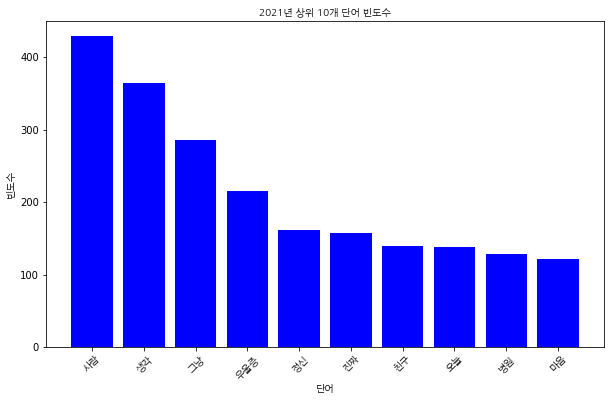

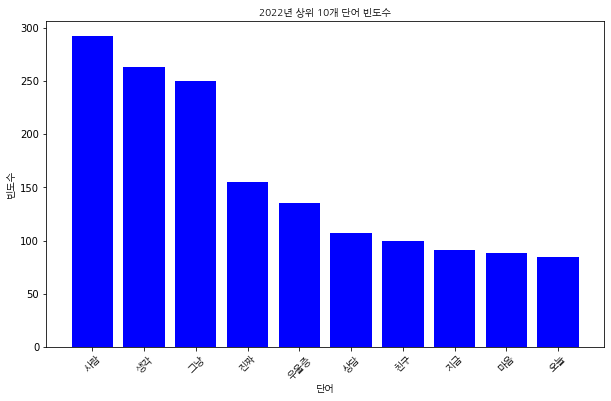

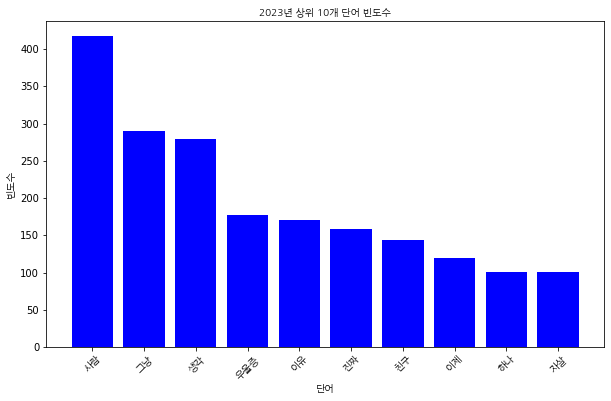

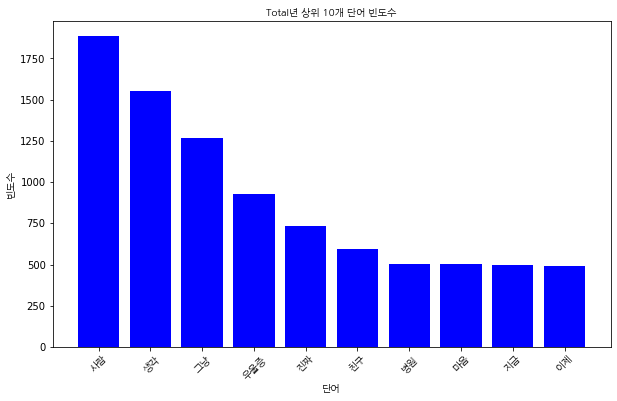

In [35]:
import matplotlib as mpl
mpl.font_manager._rebuild()
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = 'C:/Users/82106/Desktop/3-1/응데분/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
fm._rebuild()  # 폰트 캐시 재설정

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 폰트가 제대로 설정되었는지 확인
print(plt.rcParams['font.family'])

# 가정: 데이터프레임은 df라는 이름으로 이미 로드되어 있음
# 예시 데이터프레임 생성 (실제 데이터프레임으로 대체해야 함)
# df = pd.DataFrame({
#     'token': [['단어1', '단어2'], ['단어1'], ...], # 각 행은 토큰화된 단어 리스트
# })

df_2019 = df.iloc[0:848]
df_2020 = df.iloc[848:1856]
df_2021 = df.iloc[1856:3356]
df_2022 = df.iloc[3356:4519]
df_2023 = df.iloc[4519:6082]

def calculate_word_frequencies(df):
    tokens = df['tokens'].explode().dropna()
    return Counter(tokens)

freq_2019 = calculate_word_frequencies(df_2019)
freq_2020 = calculate_word_frequencies(df_2020)
freq_2021 = calculate_word_frequencies(df_2021)
freq_2022 = calculate_word_frequencies(df_2022)
freq_2023 = calculate_word_frequencies(df_2023)
freq_total = calculate_word_frequencies(df)

def freq_to_dataframe(freq, year):
    df_freq = pd.DataFrame(freq.items(), columns=['Word', 'Count'])
    df_freq = df_freq.sort_values(by='Count', ascending=False).reset_index(drop=True)
    df_freq['Year'] = year
    return df_freq

df_freq_2019 = freq_to_dataframe(freq_2019, 2019)
df_freq_2020 = freq_to_dataframe(freq_2020, 2020)
df_freq_2021 = freq_to_dataframe(freq_2021, 2021)
df_freq_2022 = freq_to_dataframe(freq_2022, 2022)
df_freq_2023 = freq_to_dataframe(freq_2023, 2023)
df_freq_total = freq_to_dataframe(freq_total, 'Total')

print("Word Frequencies 2019")
print(df_freq_2019.head(10))
print("\nWord Frequencies 2020")
print(df_freq_2020.head(10))
print("\nWord Frequencies 2021")
print(df_freq_2021.head(10))
print("\nWord Frequencies 2022")
print(df_freq_2022.head(10))
print("\nWord Frequencies 2023")
print(df_freq_2023.head(10))
print("\nTotal Word Frequencies")
print(df_freq_total.head(10))

def plot_word_frequencies(df_freq, year):
    plt.figure(figsize=(10, 6))
    plt.bar(df_freq['Word'][:10], df_freq['Count'][:10], color='blue')
    plt.xlabel('단어', fontproperties=fontprop)
    plt.ylabel('빈도수', fontproperties=fontprop)
    plt.title(f'{year}년 상위 10개 단어 빈도수', fontproperties=fontprop)
    plt.xticks(rotation=45, fontproperties=fontprop)
    plt.show()

plot_word_frequencies(df_freq_2019, 2019)
plot_word_frequencies(df_freq_2020, 2020)
plot_word_frequencies(df_freq_2021, 2021)
plot_word_frequencies(df_freq_2022, 2022)
plot_word_frequencies(df_freq_2023, 2023)
plot_word_frequencies(df_freq_total, 'Total')


#### 주로 나오는 단어들을 보면 사람, 생각, 우울증, 그냥, 진짜 등이 있다.
#### 여기서 '하나'는 '죽어야하나', '~해야하나' 등에서 noun으로 잘못 추출된 토큰들로 파악된다.

하지만 우리가 원하는 것은 이게 아니다. 단순히 게시글 내의 단어 빈도가 아닌, TF-IDF를 통해 전체 문서에서의 상대적인 중요성도 고려하여 게시글의 주제를 찾을 것이다.

사람, 우울증, 그냥, 진짜 등 게시글의 주제라고 판단되지 않지만 자주 나오는 용어들을 모두 불용어로 넣었다.

이후 TF-IDF과정을 거치고 K-means clustering을 했다.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from wordcloud import WordCloud


# 불용어 리스트 확장
additional_stopwords = {'계속','사람', '우울증', '우울','하루','혹시','정도','생각', '지금','그냥', '진짜', '이제', '정말', '오늘', '이유','인생','시간','스스로', '아무', '자신', '여기','혼자','기분','때문','하나','세상','사실','보고','해도','다시'}

def removing_stopwords(words):
    stopwords = {'이다', '있다'}.union(additional_stopwords)
    return [word for word in words if len(word) > 1 and word not in stopwords]

df['tokens'] = df['tokens'].apply(lambda x: removing_stopwords(x))
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(df['processed_text'])

# K-means 클러스터링
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# 실루엣 점수 계산
score = silhouette_score(X, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.3193386963262077


실루엣 점수는 0.31점으로 실루엣 점수 (-1(bad) ~ 1(good))를 고려해봤을때 나쁘진 않지만 그렇다고 좋은 모델이 나온 것 같지도 않다.


Cluster 0 common words:
엄마
정신과
요즘
학교
상담

Cluster 1 common words:
자살
고통
엄마
공부
제발

Cluster 2 common words:
친구
가족
연락
얘기
마음

Cluster 3 common words:
도움
상담
조금
마음
정신과

Cluster 4 common words:
병원
마음
상담
정신과
처음


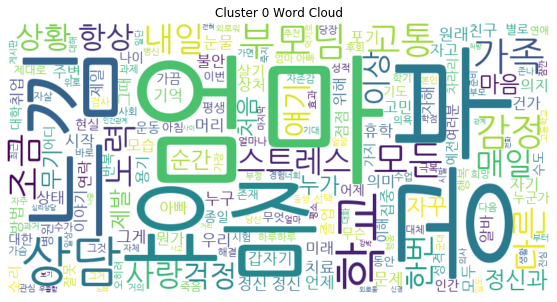

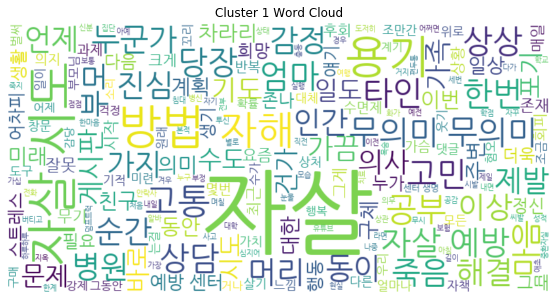

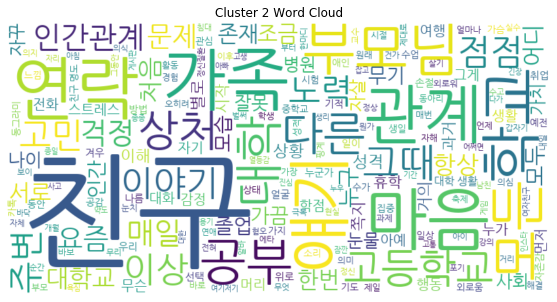

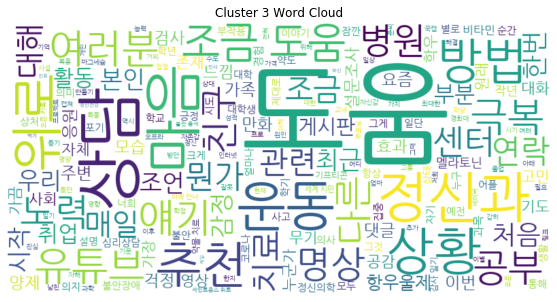

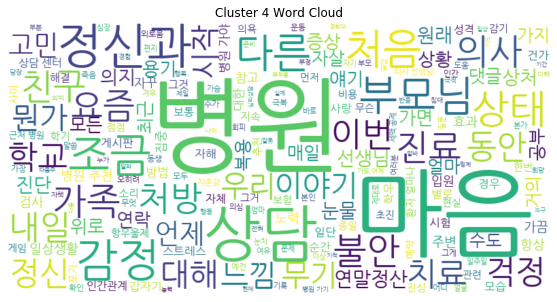


Cluster 0 posts:
니네들 다 인싸이면서 왜 아싸인척 하냐?
진짜 아싸 기만하니까 좋냐?
나만 힘들고 나만 심해속에 가라앉아 사는 것 같은데 나말고도 이런 애들이 많구나... 힘내자 얘들아
종현아 보고싶어 종현아

Cluster 1 posts:
헐떡고개에서 버스올 타이밍에 맞춰서 경사심한 도로에 스케이트보드타고 존나세게 내려가는 상상 많이함 관종이 자살하는 방법ㅋㅋ
내가 자살하면 더더욱 불행한 사람이 될 여리고 불쌍한 우리엄마 때문에 맘대로 죽어버릴 수도 없는 비참한 하루들
자살하면 개죽음이겠지?

근데 너무 힘들어........

아까도 길 걷다가 너무 힘들어서 펑펑울었다....

인간관계도, 공부도, 집안문제도 뭐 하나 내 뜻대로 되는게 없네.....

그냥 다 내려놓고 영영 편하게 쉴 수 있었으면...

이 고통에서 벗어났으면 좋겠어

Cluster 2 posts:
얘기 들어줄게 힘든사람들은 쪽지해줘.

난 지금은 우울증 없고 몇년전에 1년동안 우울증이었어. 나는 쫄보라서 그때 당시는 병원기록남는게 두려워서 병원 안가고 혼자 일년 버텼었어.

정말 매일 매순간 숨쉬는거랑 동시에 울었어.
가족들 걱정할까봐 집에서는 어른들 앞에서 씩씩한척 하고 바로 방에들어와서 이불뒤집어 쓰고 누워서 울었어. 울다가 코막혀서 코풀고싶었는데 코푸는 소리들으시면 내가 우울증인거 들킬까봐 안풀고 계속 숨어서 울다가 지금은 비염도생겼어

비염은 여담이었고 아무튼 나는 웃는 법을 까먹었었어

그러다가 정말 다행히도 조금씩 웃으면서 우는걸 멈출수 있다는 걸 깨달았어.

우울증 걸린 자세한 사연은 말을 못해주지만
무기력해지거나 그런건 아니었어. 의욕이없는거랑은 좀 다른이유였어. 사람에 대한 상처였어.
진짜 죽을까 매일 고민했는데 그 당시를 기준으로 일년 후에 그리고 지금 돌이켜보면 안죽고 지금까지 살아숨쉬는게 너무 다행인것같아. 고등학생때 일이니까 그때 죽었으면 정말 억울했을것 같아..

그때의 나처럼 눈물 멈추는 법을 까먹은 친구들이 있을거야. 나는 그런 친구를 보면 나를

In [59]:
# 클러스터 중심 단어 추출
terms = vectorizer.get_feature_names()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for cluster in range(num_clusters):
    print(f"\nCluster {cluster} common words:")
    for idx in order_centroids[cluster, :5]:
        print(terms[idx])

def plot_wordcloud(cluster_num):
    cluster_indices = [i for i, label in enumerate(clusters) if label == cluster_num]
    cluster_texts = ' '.join(df.iloc[cluster_indices]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='C:/Users/82106/Desktop/3-1/응데분/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf').generate(cluster_texts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_num} Word Cloud')
    plt.show()

for i in range(num_clusters):
    plot_wordcloud(i)
    
for cluster in range(num_clusters):
    print(f"\nCluster {cluster} posts:")
    cluster_indices = [i for i, label in enumerate(clusters) if label == cluster]
    for idx in cluster_indices[:3]:  # 각 클러스터에서 대표적인 3개 게시물 출력
        print(df.iloc[idx]['combined_text'])

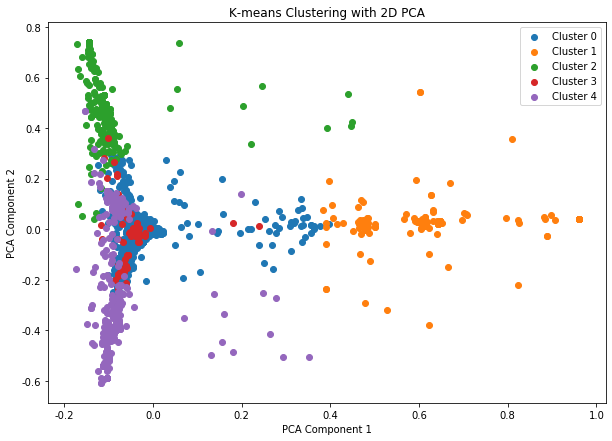

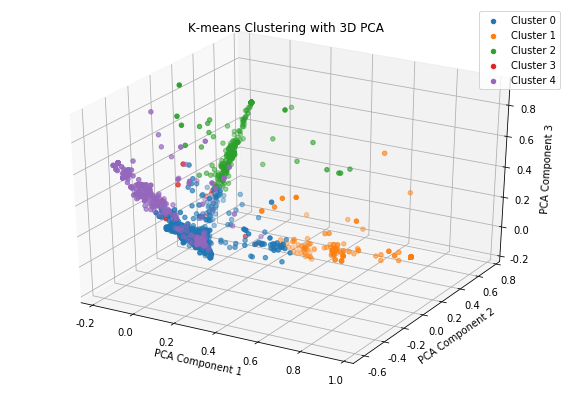

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
for cluster in range(num_clusters):
    cluster_indices = np.where(clusters == cluster)
    plt.scatter(X_pca_2d[cluster_indices, 0], X_pca_2d[cluster_indices, 1], label=f'Cluster {cluster}')
plt.title('K-means Clustering with 2D PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X.toarray())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(num_clusters):
    cluster_indices = np.where(clusters == cluster)
    ax.scatter(X_pca_3d[cluster_indices, 0], X_pca_3d[cluster_indices, 1], X_pca_3d[cluster_indices, 2], label=f'Cluster {cluster}')
ax.set_title('K-means Clustering with 3D PCA')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()


#### 경희대학교 우울증 갤러리의 주제는 '엄마', '가족', '공부', '정신과', '병원'임을 알 수 있다. 비록 가설과는 달랐지만, 의미있는 인사이트를 얻었다.

 '엄마', '가족', '공부', '정신과', '병원'이라는 주제에서, 주로 공부와 가족이 우울증에 중요한 영향을 미친다는 것을 알 수 있다.
<br> <br>
또한 정신과와 병원이 주요 주제로 등장하는 것은 많은 학생들이 정신 건강 문제로 전문적인 도움을 찾고 있다는 것을 나타낸다.
<br> <br>
하지만 정신과와 병원에 대한 주요 게시글들을 찾아본 결과, '정신과 도움 될까요?', '병원 가면 진료 기록 남나요?'와 같은 글들이 많았다.
<br>
이는 학생들이 정신 건강 문제에 대한 인식과 접근에 대한 불안감을 가지고 있다는 것을 의미한다.
<br><br>
이에 학교에서는 정신과 및 병원 이용에 대한 정보 제공과 함께 우울증에 대한 접근성을 높힐 필요가 있다고 생각한다. 에브리타임 내에서 교내 정신 상담 프로그램, 소책자, 설명회 등을 홍보하여 학생들의 정신 건강 관리 서비스에 대한 접근성을 높이고, 교내의 정신 건강 관련 프로그램 혹은 상담에서 학생들의 진료 기록 관리 과정에 대한 익명성을 보장해준다면 학생들의 불안감을 줄이고 더 많은 학생들이 필요한 도움을 받을 수 있을 것이다. 이를 통해 학생들의 정신 건강 문제를 보다 효과적으로 관리하고, 예방할 수 있는 환경을 조성할 수 있을 것이다.

추가적으로 **년도별 게시글들의 주제가 다를까?** 라는 궁금증에, 각 년도 별로 클러스터링을 진행해보았다.

2019 Silhouette Score: 0.27812334326090815

2019 Cluster 0 common words:
자살
엄마
친구
상담
상황

2019 Cluster 1 common words:
제발
고통
누가
모든
정신

2019 Cluster 2 common words:
고통
자살
대체
불안
정신

2019 Cluster 3 common words:
병원
상담
처음
도움
내일

2019 Cluster 4 common words:
마음
방법
불안
누구
상처


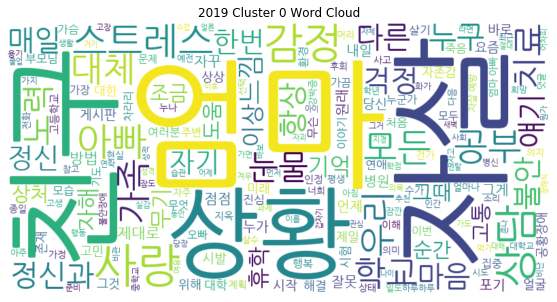

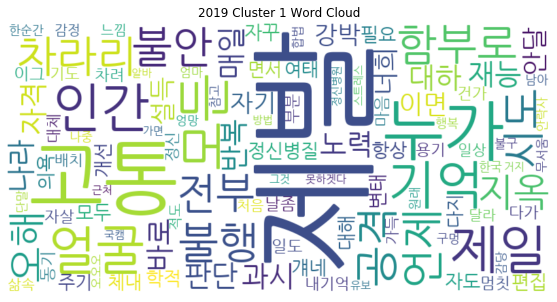

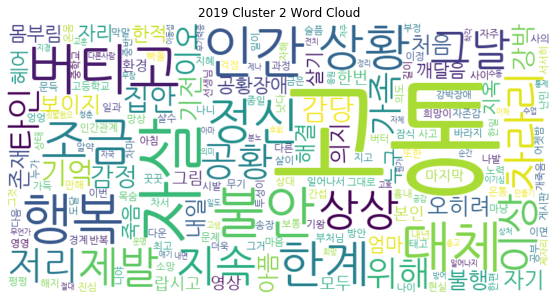

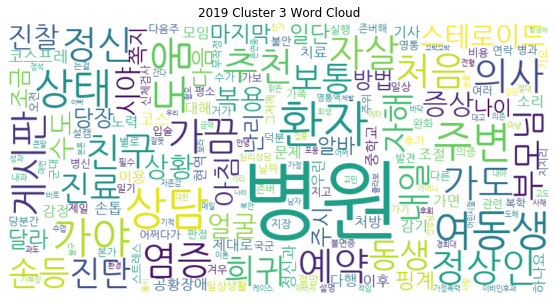

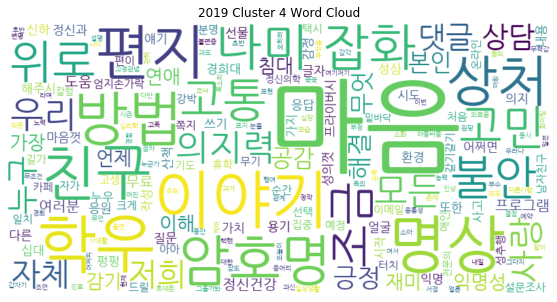

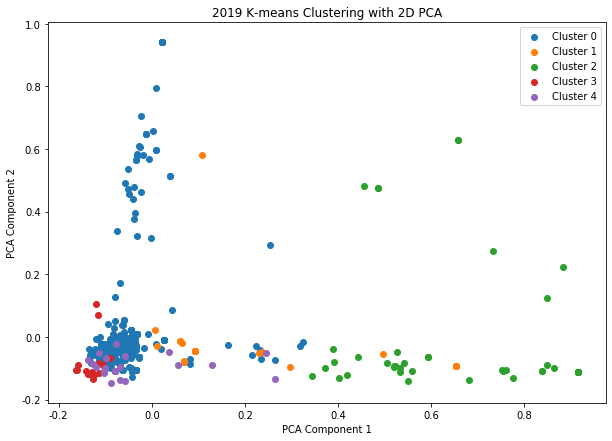

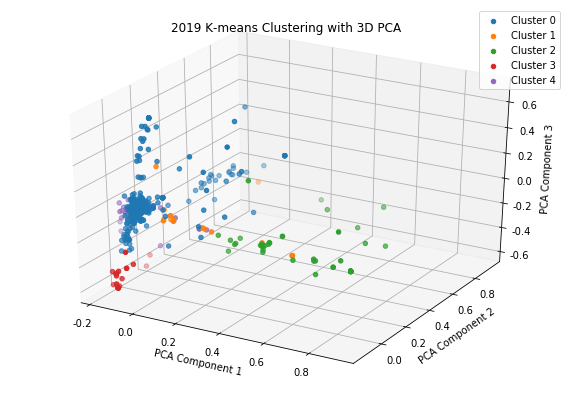

2020 Silhouette Score: 0.2629032199837115

2020 Cluster 0 common words:
마음
친구
엄마
감정
공부

2020 Cluster 1 common words:
상담
치료
학교
병원
도움

2020 Cluster 2 common words:
자살
마음
요즘
감정
엄마

2020 Cluster 3 common words:
병원
무기
부모님
의사
감정

2020 Cluster 4 common words:
얘기
정신과
친구
가족
자살


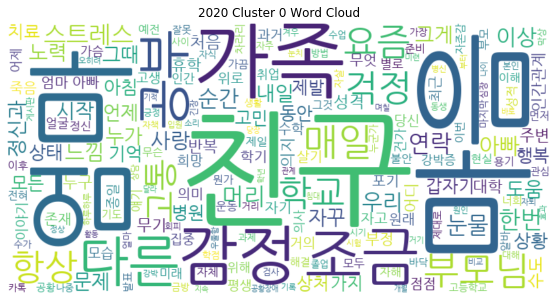

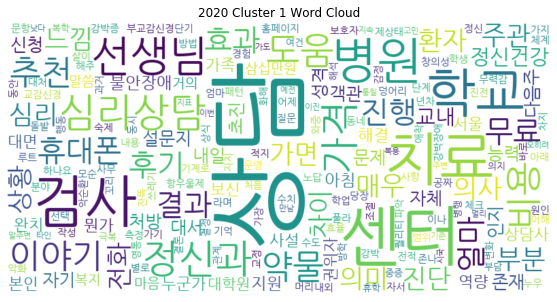

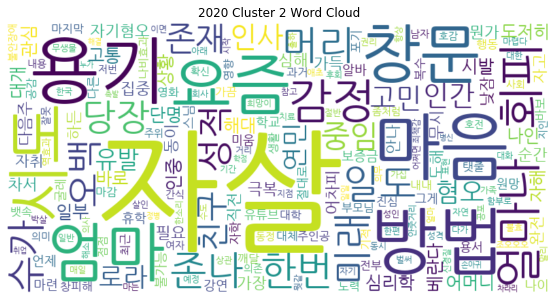

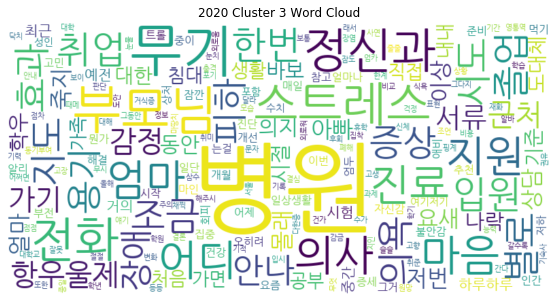

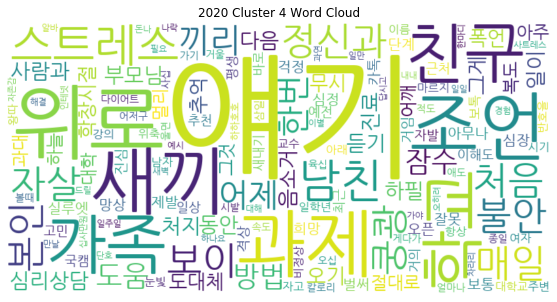

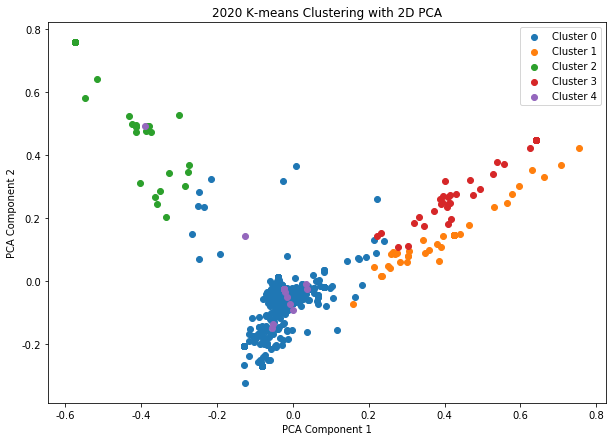

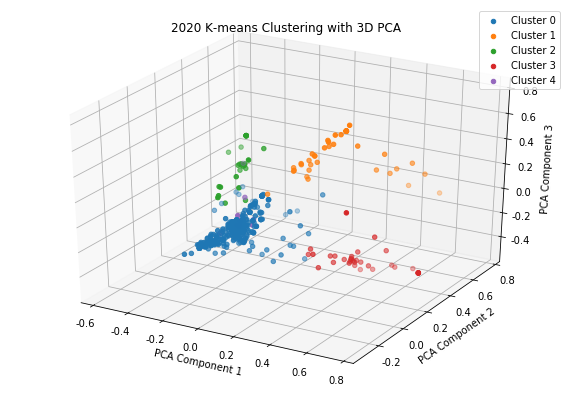

2021 Silhouette Score: 0.3145064264670896

2021 Cluster 0 common words:
처음
병원
정신과
상담
아빠

2021 Cluster 1 common words:
병원
정신과
상담
공부
엄마

2021 Cluster 2 common words:
마음
가족
모든
항상
병원

2021 Cluster 3 common words:
자살
공부
한번
병원
방법

2021 Cluster 4 common words:
친구
가족
연락
학교
얘기


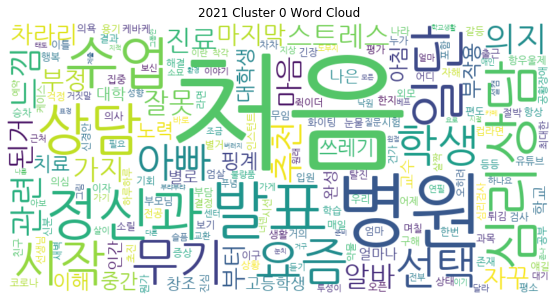

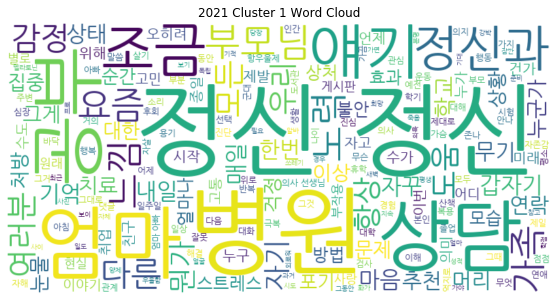

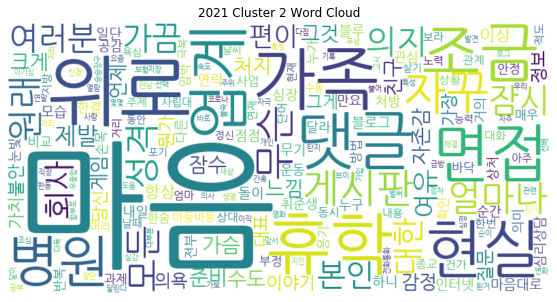

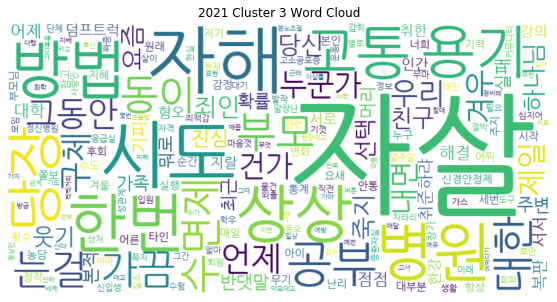

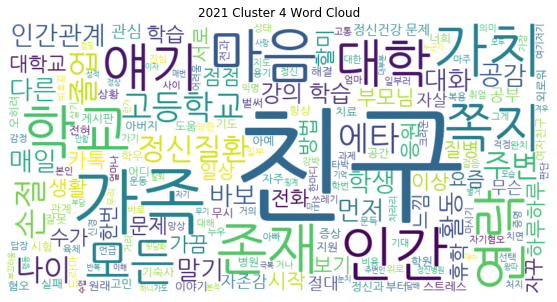

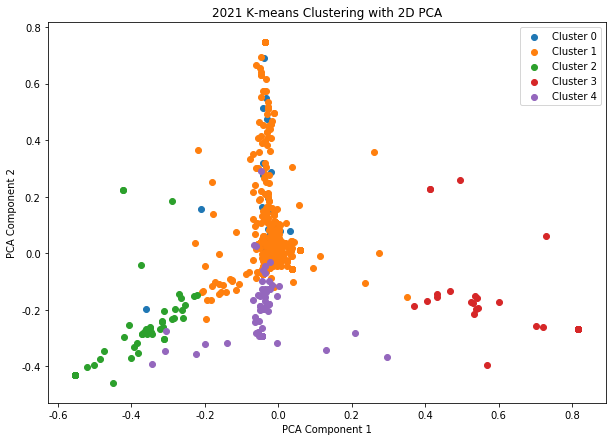

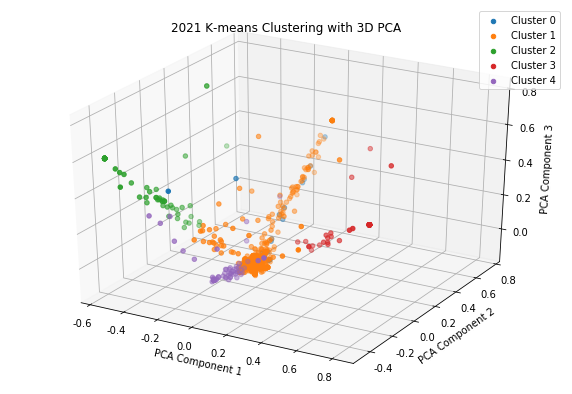

2022 Silhouette Score: 0.30910107088847594

2022 Cluster 0 common words:
병원
자살
마음
요즘
내일

2022 Cluster 1 common words:
상담
학교
정신과
요즘
병원

2022 Cluster 2 common words:
엄마
이상
매일
친구
걱정

2022 Cluster 3 common words:
정신과
처음
요즘
상담
얘기

2022 Cluster 4 common words:
친구
마음
이상
가족
고민


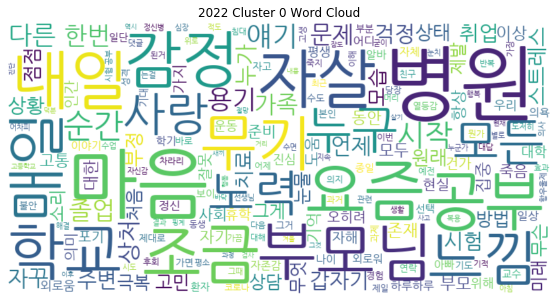

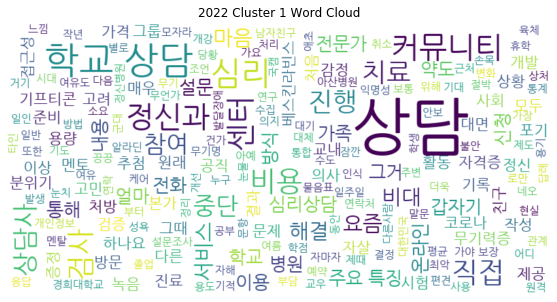

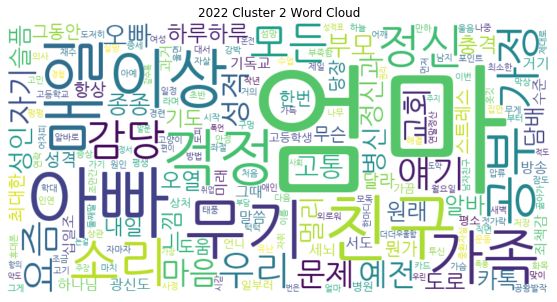

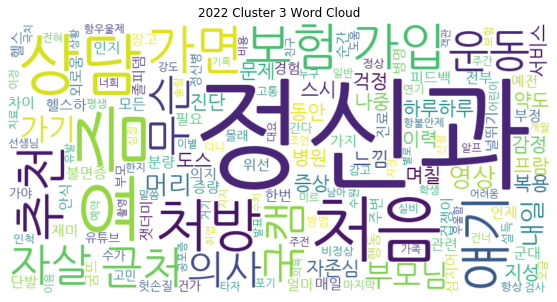

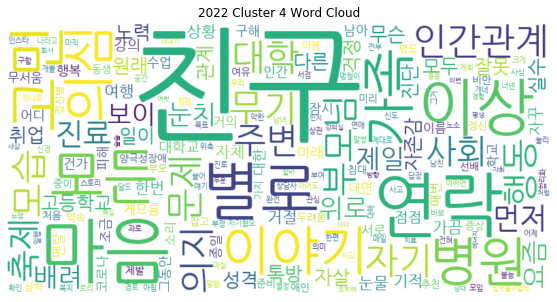

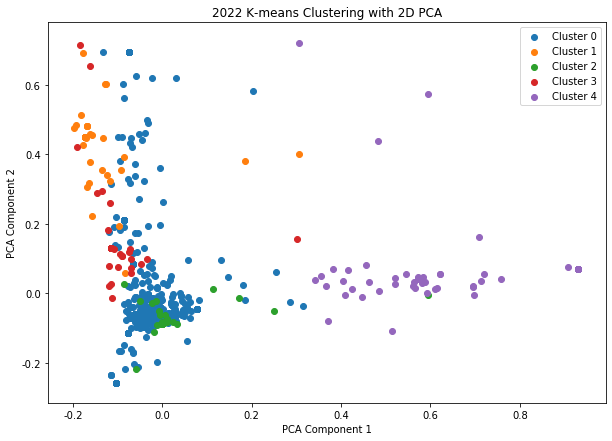

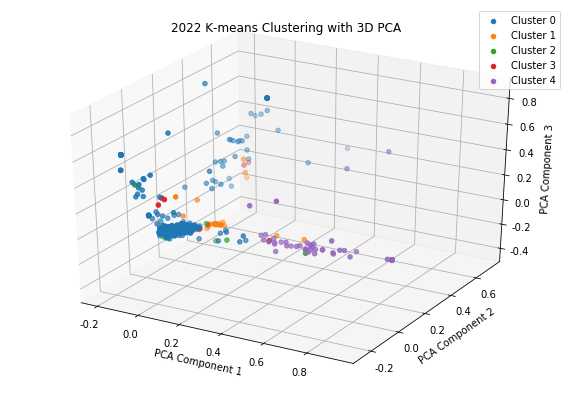

2023 Silhouette Score: 0.3404273513310037

2023 Cluster 0 common words:
친구
마음
미래
정신과
내일

2023 Cluster 1 common words:
누가
갑자기
엄마
친구
제발

2023 Cluster 2 common words:
제발
자살
미래
내일
의미

2023 Cluster 3 common words:
병원
정신과
상담
처음
정신

2023 Cluster 4 common words:
자살
포기
자꾸
엄마
스트레스


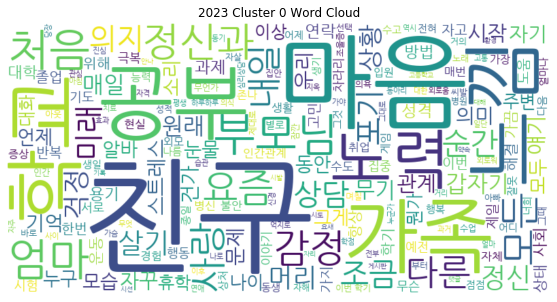

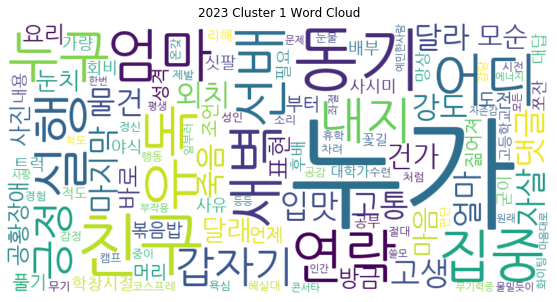

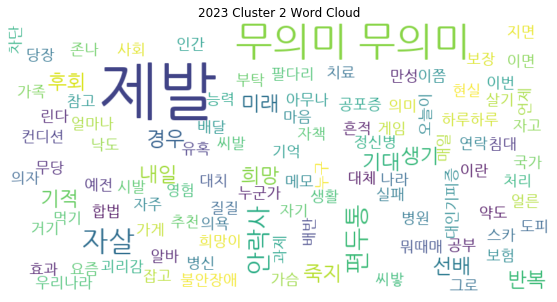

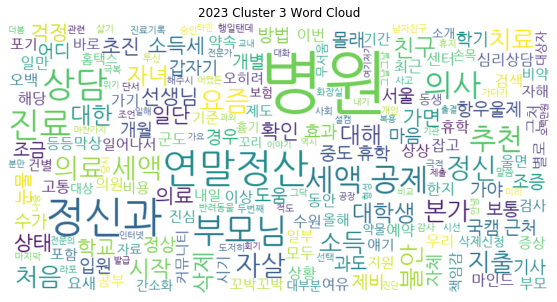

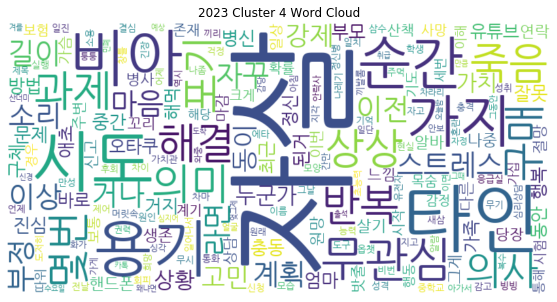

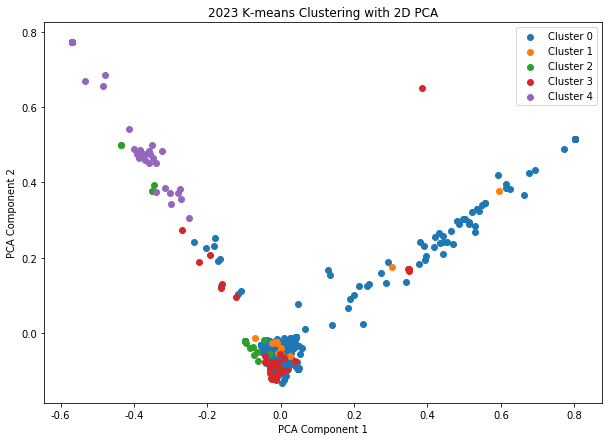

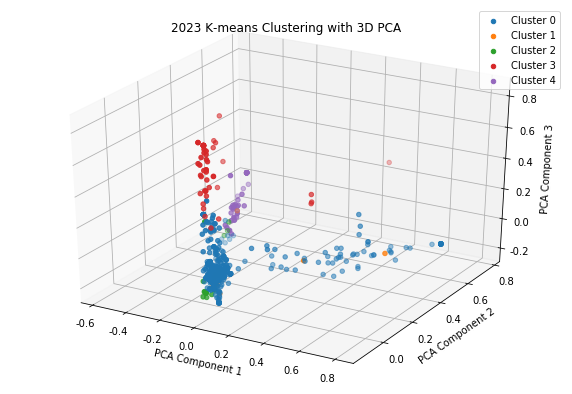

In [63]:
df['tokens'] = df['tokens'].apply(lambda x: removing_stopwords(x))
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

df_2019 = df.iloc[0:848]
df_2020 = df.iloc[848:1856]
df_2021 = df.iloc[1856:3356]
df_2022 = df.iloc[3356:4519]
df_2023 = df.iloc[4519:6082]

# 불용어 리스트 확장
additional_stopwords = {'계속','사람', '우울증', '우울','하루','혹시','정도','생각', '지금','그냥', '진짜', '이제', '정말', '오늘', '이유','인생','시간','스스로', '아무', '자신', '여기','혼자','기분','때문','하나','세상','사실','보고','해도','다시'}

def removing_stopwords(words):
    stopwords = {'이다', '있다'}.union(additional_stopwords)
    return [word for word in words if len(word) > 1 and word not in stopwords]

df['tokens'] = df['tokens'].apply(lambda x: removing_stopwords(x))
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
def analyze_yearly_data(df, year):
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(max_features=50)
    X = vectorizer.fit_transform(df['processed_text'])

    # K-means 클러스터링
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)

    # 실루엣 점수 계산
    score = silhouette_score(X, clusters)
    print(f'{year} Silhouette Score: {score}')

    # 클러스터 중심 단어 추출
    terms = vectorizer.get_feature_names()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    for cluster in range(num_clusters):
        print(f"\n{year} Cluster {cluster} common words:")
        for idx in order_centroids[cluster, :5]:
            print(terms[idx])

    def plot_wordcloud(cluster_num):
        cluster_indices = [i for i, label in enumerate(clusters) if label == cluster_num]
        cluster_texts = ' '.join(df.iloc[cluster_indices]['processed_text'])
        wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(cluster_texts)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{year} Cluster {cluster_num} Word Cloud')
        plt.show()

    for i in range(num_clusters):
        plot_wordcloud(i)

    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X.toarray())

    plt.figure(figsize=(10, 7))
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)
        plt.scatter(X_pca_2d[cluster_indices, 0], X_pca_2d[cluster_indices, 1], label=f'Cluster {cluster}')
    plt.title(f'{year} K-means Clustering with 2D PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    pca_3d = PCA(n_components=3)
    X_pca_3d = pca_3d.fit_transform(X.toarray())

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    for cluster in range(num_clusters):
        cluster_indices = np.where(clusters == cluster)
        ax.scatter(X_pca_3d[cluster_indices, 0], X_pca_3d[cluster_indices, 1], X_pca_3d[cluster_indices, 2], label=f'Cluster {cluster}')
    ax.set_title(f'{year} K-means Clustering with 3D PCA')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()

analyze_yearly_data(df_2019, 2019)
analyze_yearly_data(df_2020, 2020)
analyze_yearly_data(df_2021, 2021)
analyze_yearly_data(df_2022, 2022)
analyze_yearly_data(df_2023, 2023)


하지만 이 과정에서 년도 별로 특정 키워드가 눈에 띄게 존재하진 않았다.

## 가설 3: 늦은 새벽에 사람들의 활동률이 가장 높을 것이다.

> 시간대별 게시물 수를 그래프로 표현하여 사람들이 어느 시간에 가장 활발한지 파악한다.<br>
회귀 모델을 만들 것이고 게시글이 가장 많았던 4월을 data로 넣을 것이다. 2019년 4월, 2020년 4월, 2021년 4월, 2022년 4월의 시간대별 게시물 수를 train data로한다. 2023년 4월의 시간대별 게시글 수를 예측할 것이다.

먼저 2019 ~ 2022년 4월의 data를 시각화한다.

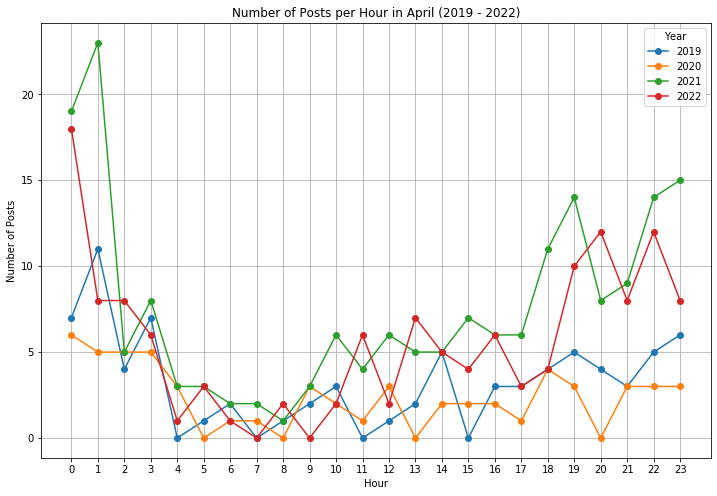

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

file_path = 'C:/Users/82106/Desktop/3-1/응데분/Project_data/everytime_posts_combined_sorted.xlsx'
data = pd.read_excel(file_path)

april_data = data[(data['Year'].isin([19, 20, 21, 22])) & (data['Month'] == 4)]

posts_per_hour_yearly = april_data.groupby(['Year', 'Hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))

years = [19, 20, 21, 22]
for year in years:
    plt.plot(posts_per_hour_yearly.loc[year], 'o-', label=f'20{year}')

plt.xlabel('Hour')
plt.ylabel('Number of Posts')
plt.title('Number of Posts per Hour in April (2019 - 2022)')
plt.xticks(range(24))  # Ensuring all hours are shown
plt.legend(title='Year')
plt.grid(True)
plt.show()

이후 2019년부터 2022년까지의 4월 data로 2023년 4월의 data를 예측하는 모델을 만들고, test에서 성능을 평가해보았다.

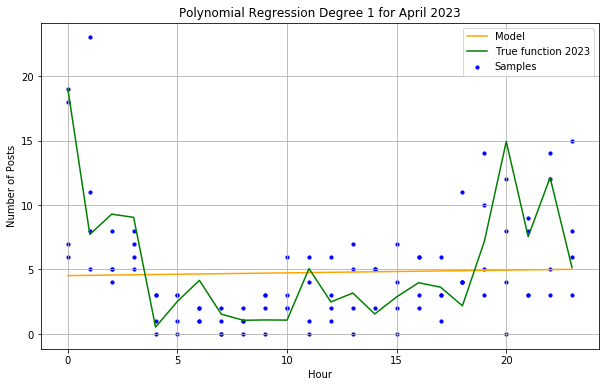

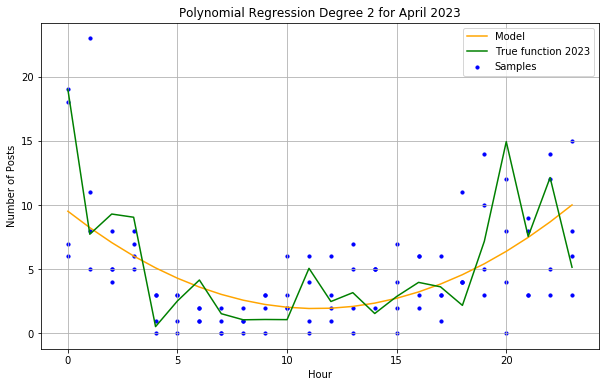

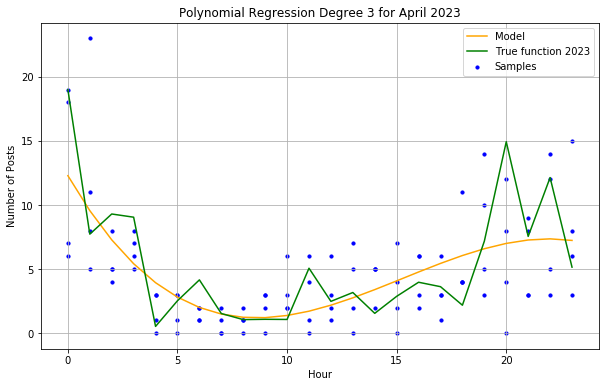

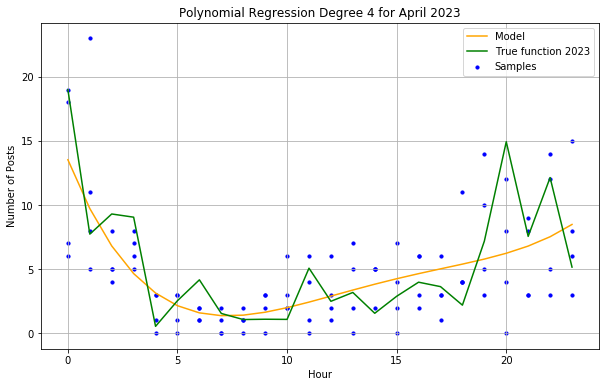

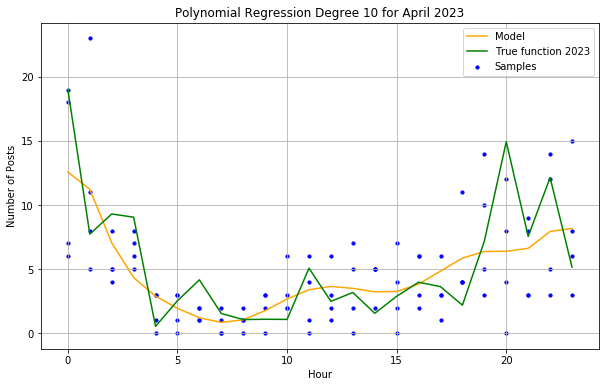

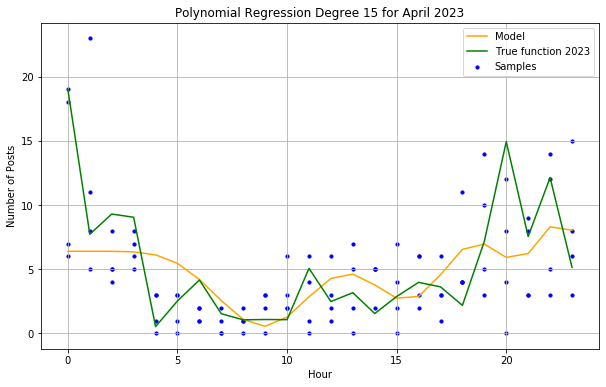

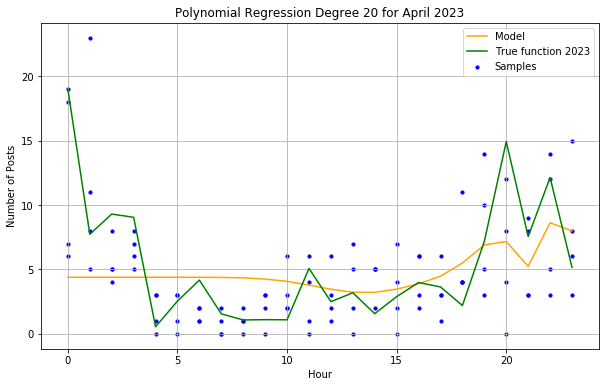

Train MSE  Train MAE  Train RMSE  Train R2   Test MSE  Test MAE  \
1   18.988234   3.171584    4.357549  0.001144  21.971318  3.500286   
2   12.596563   2.675871    3.549164  0.337371  11.044259  2.290393   
3   10.788095   2.472910    3.284523  0.432504   8.660618  2.081296   
4   10.390564   2.400655    3.223440  0.453415   8.821429  2.201058   
10  10.017823   2.420188    3.165095  0.473023   9.267378  2.229817   
15  14.491670   2.833866    3.806793  0.237681  14.981026  2.556236   
20  16.988702   3.057603    4.121735  0.106327  17.923948  2.967665   

    Test RMSE   Test R2  
1    4.687357 -0.018924  
2    3.323290  0.487821  
3    2.942893  0.598362  
4    2.970089  0.590905  
10   3.044237  0.570224  
15   3.870533  0.305252  
20   4.233668  0.168774

In [11]:
import numpy as np
hours = posts_per_hour_yearly.columns.values.reshape(-1, 1)
X = np.tile(hours, (4, 1))  # Hours (0-23) repeated for each year
y = posts_per_hour_yearly.values.flatten()  # Corresponding post counts

np.random.seed(42)
true_function_2023 = posts_per_hour_yearly.loc[22].values + np.random.normal(scale=2, size=24)

def evaluate_model(model, X_poly, y, X_test, y_test):
    y_pred_train = model.predict(X_poly)
    mse = mean_squared_error(y, y_pred_train)
    mae = mean_absolute_error(y, y_pred_train)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred_train)
    
    y_pred_test = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred_test)
    
    return mse, mae, rmse, r2, y_pred_train, y_pred_test, test_mse, test_mae, test_rmse, test_r2

def evaluate_and_plot_model(degree, X, y, true_function_2023, hours):
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    X_test = poly.transform(hours)
    mse, mae, rmse, r2, y_pred_train, y_pred_test, test_mse, test_mae, test_rmse, test_r2 = evaluate_model(model, X_poly, y, X_test, true_function_2023)
    
    plt.figure(figsize=(10, 6))
    plt.plot(hours, y_pred_test, label='Model', color='orange')
    plt.scatter(X, y, color='blue', s=10, label='Samples')
    plt.plot(hours, true_function_2023, label='True function 2023', color='green')
    plt.xlabel('Hour')
    plt.ylabel('Number of Posts')
    plt.title(f'Polynomial Regression Degree {degree} for April 2023')
    plt.legend()
    plt.grid(True)
    plt.show()

    return mse, mae, rmse, r2, test_mse, test_mae, test_rmse, test_r2

results = {}

degrees = [1, 2, 3, 4, 10, 15, 20]

for degree in degrees:
    mse, mae, rmse, r2, test_mse, test_mae, test_rmse, test_r2 = evaluate_and_plot_model(degree, X, y, true_function_2023, hours)
    results[degree] = {
        'Train MSE': mse, 'Train MAE': mae, 'Train RMSE': rmse, 'Train R2': r2,
        'Test MSE': test_mse, 'Test MAE': test_mae, 'Test RMSE': test_rmse, 'Test R2': test_r2
    }

results_df = pd.DataFrame(results).T

results_df


이를 통해 모델의 예측과 실제 데이터(추정 값)의 비교를 확인할 수 있으며, 차수가 너무 높아질 경우 모델이 과적합되는 경향을 볼 수 있다.

차수가 3 ~ 10인 경우에 가장 성능이 좋았다. <br>
<br>
하지만 MSE가 가장 낮은 10차 regression에서도 R-Squared가 0.47로 모델의 성능이 매우 좋지 않았다. <br>
<br>
표준화를 하지 않은 것이 가장 큰 이유라고 판단하였고, 표준화를 진행하였다.

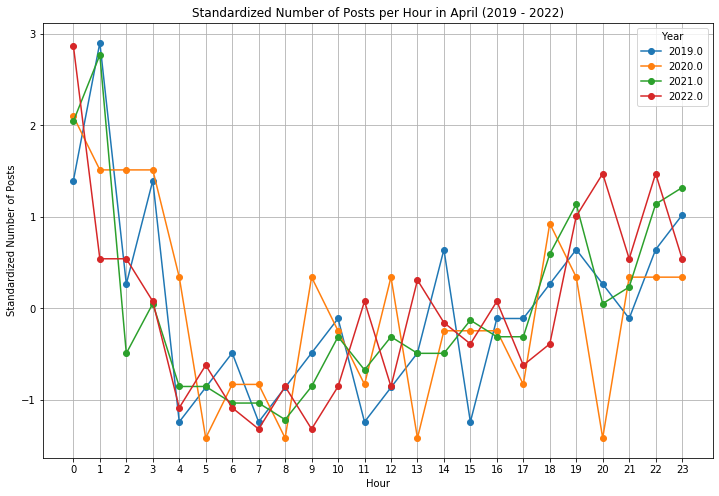

In [12]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# Standardizing the data for each year
scaler = StandardScaler()
posts_per_hour_standardized = posts_per_hour_yearly.copy()

for year in posts_per_hour_standardized.index:
    posts_per_hour_standardized.loc[year] = scaler.fit_transform(posts_per_hour_yearly.loc[year].values.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 8))

for year in posts_per_hour_standardized.index:
    plt.plot(posts_per_hour_standardized.loc[year], 'o-', label=f'20{year}')

plt.xlabel('Hour')
plt.ylabel('Standardized Number of Posts')
plt.title('Standardized Number of Posts per Hour in April (2019 - 2022)')
plt.xticks(range(24))  # Ensuring all hours are shown
plt.legend(title='Year')
plt.grid(True)
plt.show()

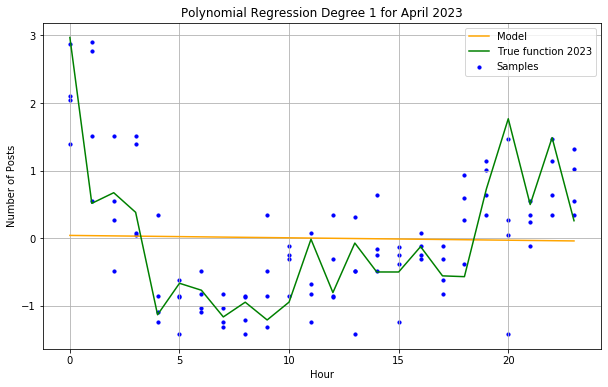

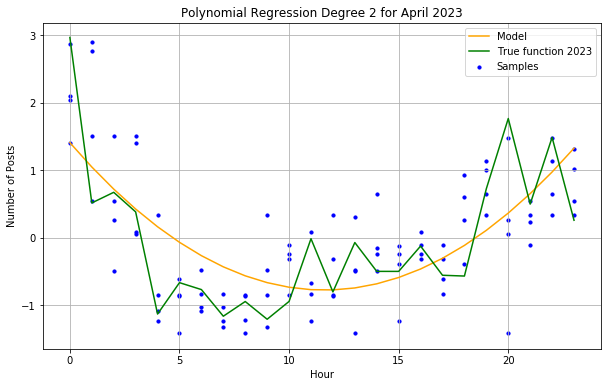

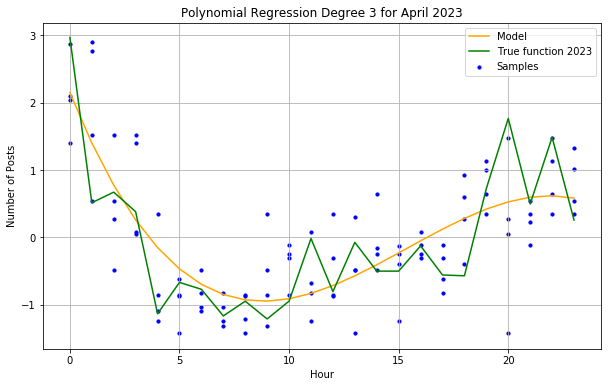

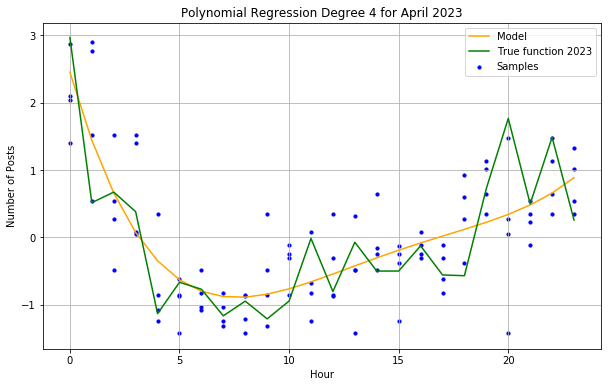

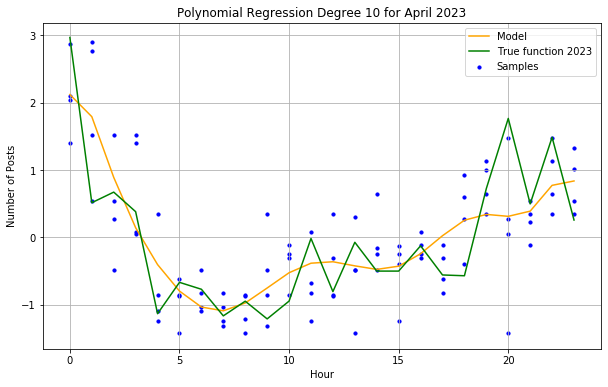

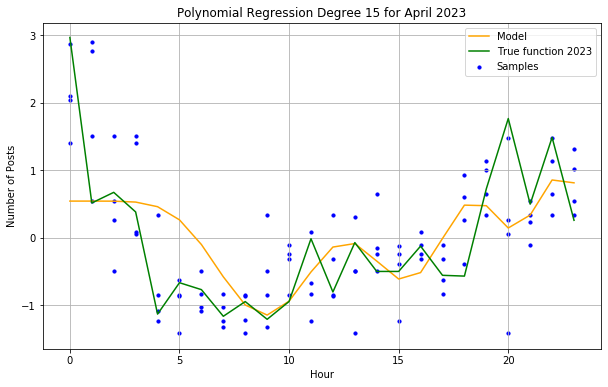

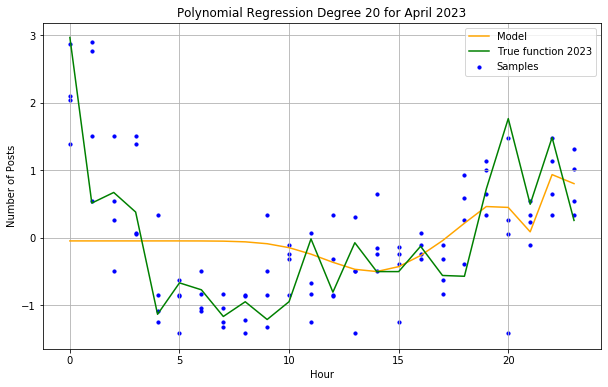

Train MSE  Train MAE  Train RMSE  Train R2  Test MSE  Test MAE  Test RMSE  \
1    0.999397   0.801120    0.999699  0.000603  1.029254  0.804581   1.014521   
2    0.518781   0.589382    0.720265  0.481219  0.469193  0.540967   0.684977   
3    0.388651   0.477581    0.623419  0.611349  0.306711  0.418213   0.553815   
4    0.365223   0.456240    0.604337  0.634777  0.292062  0.415825   0.540428   
10   0.332989   0.437615    0.577052  0.667011  0.336663  0.446300   0.580227   
15   0.666064   0.627494    0.816128  0.333936  0.659892  0.553279   0.812338   
20   0.876902   0.699439    0.936430  0.123098  0.833488  0.697408   0.912956   

     Test R2  
1  -0.005429  
2   0.541668  
3   0.700389  
4   0.714699  
10  0.671130  
15  0.355383  
20  0.185805

In [13]:
hours = posts_per_hour_standardized.columns.values.reshape(-1, 1)
X = np.tile(hours, (4, 1))  # Hours (0-23) repeated for each year
y = posts_per_hour_standardized.values.flatten()  # Corresponding standardized post counts

np.random.seed(42)
true_function_2023 = posts_per_hour_standardized.loc[22].values + np.random.normal(scale=0.2, size=24)

results = {}

degrees = [1, 2, 3, 4, 10, 15, 20]

for degree in degrees:
    mse, mae, rmse, r2, test_mse, test_mae, test_rmse, test_r2 = evaluate_and_plot_model(degree, X, y, true_function_2023, hours)
    results[degree] = {
        'Train MSE': mse, 'Train MAE': mae, 'Train RMSE': rmse, 'Train R2': r2,
        'Test MSE': test_mse, 'Test MAE': test_mae, 'Test RMSE': test_rmse, 'Test R2': test_r2
    }

results_df = pd.DataFrame(results).T
results_df


표준화 이후의 과정에서도 Train R2가 0.66으로 그리 좋지 않았다. Test R2가 더 높은 것으로 보아 Data의 개수가 부족하다고 판단하였고 **SMOTE**를 통해 데이터를 증강시키기로 했다.

In [3]:
pip install scikit-learn==1.0.2 imbalanced-learn==0.9.0

  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.2
    Uninstalling imbalanced-learn-0.12.2:
      Successfully uninstalled imbalanced-learn-0.12.2
Note: you may need to restart the kernel to use updated packages.


In [14]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to increase the number of samples
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

ValueError: Unknown label type: 'continuous'

**SMOTE**를 사용하고 싶었지만, 회귀 모델에선 **SMOTE**를 사용할 수 없었다.

노이즈를 추가하기 위해 **Bootstrapping** 기법을 사용했다.

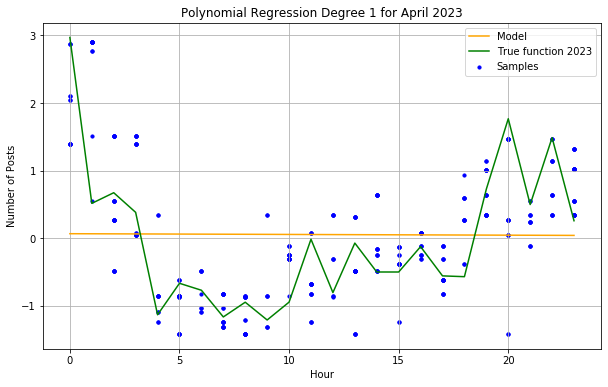

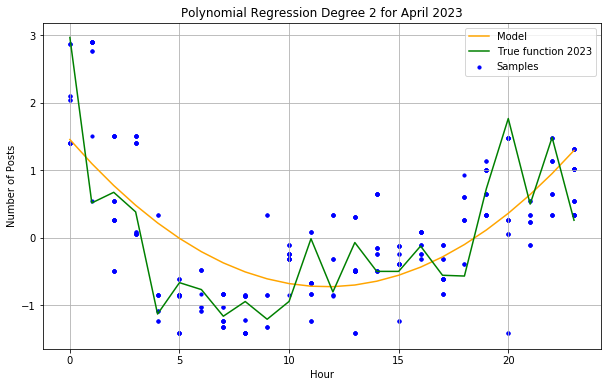

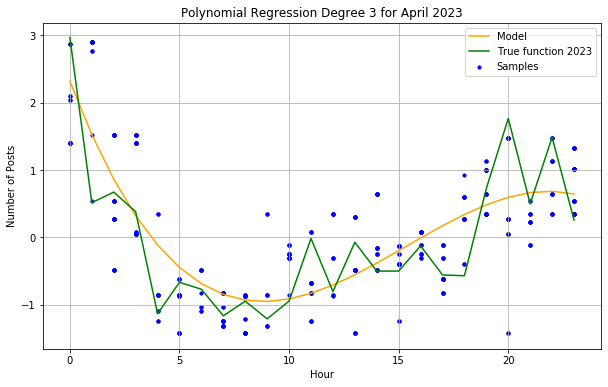

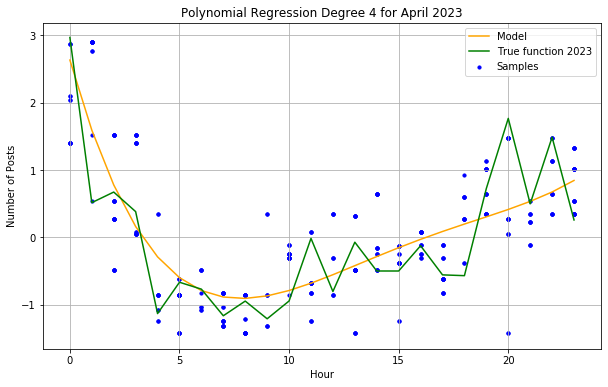

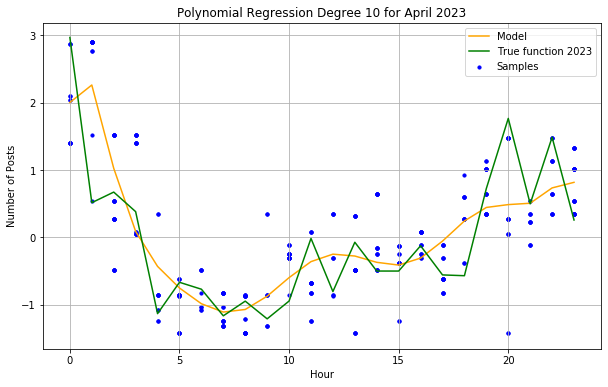

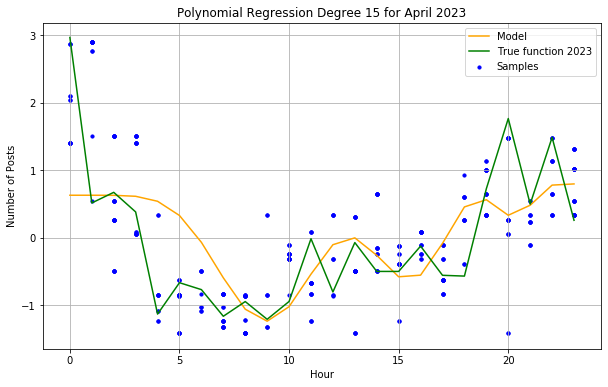

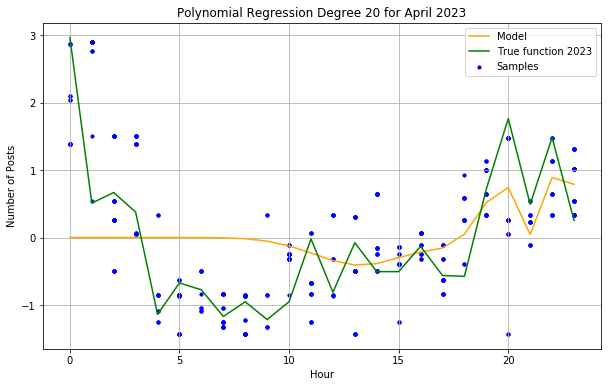

Train MSE  Train MAE  Train RMSE  Train R2  Test MSE  Test MAE  Test RMSE  \
1    1.023486   0.802941    1.011675  0.000057  1.031950  0.816491   1.015850   
2    0.540763   0.601613    0.735366  0.471676  0.479945  0.556665   0.692781   
3    0.392402   0.493048    0.626420  0.616624  0.308171  0.425273   0.555131   
4    0.373733   0.468718    0.611337  0.634864  0.295340  0.417820   0.543452   
10   0.315489   0.435890    0.561684  0.691768  0.376374  0.455372   0.613493   
15   0.652399   0.621183    0.807712  0.362608  0.639214  0.553853   0.799509   
20   0.888452   0.690299    0.942577  0.131986  0.798068  0.685031   0.893346   

     Test R2  
1  -0.008063  
2   0.531165  
3   0.698963  
4   0.711497  
10  0.632338  
15  0.375583  
20  0.220406

In [18]:
import numpy as np
from sklearn.utils import resample

def bootstrap_data(X, y, n_samples):
    X_resampled, y_resampled = resample(X, y, replace=True, n_samples=n_samples, random_state=42)
    return X_resampled, y_resampled

n_samples = 4 * len(y)
#기존 데이터의 4배
X_resampled, y_resampled = bootstrap_data(X, y, n_samples)

np.random.seed(42)
true_function_2023 = posts_per_hour_standardized.loc[22].values + np.random.normal(scale=0.2, size=24)

results = {}

degrees = [1, 2, 3, 4, 10, 15, 20]

for degree in degrees:
    mse, mae, rmse, r2, test_mse, test_mae, test_rmse, test_r2 = evaluate_and_plot_model(degree, X_resampled, y_resampled, true_function_2023, hours)
    results[degree] = {
        'Train MSE': mse, 'Train MAE': mae, 'Train RMSE': rmse, 'Train R2': r2,
        'Test MSE': test_mse, 'Test MAE': test_mae, 'Test RMSE': test_rmse, 'Test R2': test_r2
    }

results_df = pd.DataFrame(results).T
results_df


결과를 보면 R2가 10차일 때 0.69가 나온다.

기존의 데이터가 워낙 적기 때문에 데이터 증감을 시켜도 성능이 그리 좋아지지 않았다.

하지만 우린 사람들이 주로 새벽 시간에 우울증 갤러리에서 활동한다는 사실을 알 수 있었다. 또한 새롭게 게시글이 추가되어도, 우린 10시 ~ 2시 사이에 게시글이 가장 많이 포스팅될 것이고 즉 이 시간대에 우울증 갤러리가 가장 활성화된다는 사실을 알게 되었다.

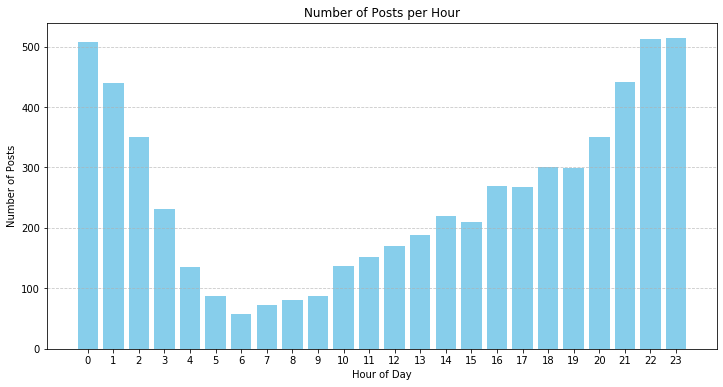

In [22]:
file_path = 'C:/Users/82106/Desktop/3-1/응데분/Project_data/everytime_posts_combined_sorted.xlsx'
df = pd.read_excel(file_path)
df['Hour'] = pd.to_datetime(df['Post Time']).dt.hour

hourly_counts = df['Hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(hourly_counts.index, hourly_counts.values, color='skyblue')
plt.title('Number of Posts per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

실제로 단순히 모든 데이터의 시간별 게시글 수를 보아도 22시부터 2시까지 게시글이 가장 많이 포스팅된 것을 알 수 있다.

------------------------------------------------------

## 결론

이번 프로젝트로 경희대학교 우울증 갤러리의 게시글 패턴을 분석했다.<br>
세 가지 주요 가설을 설정하고 이를 검증하는 과정을 통해 다양한 결과를 얻을 수 있었다.

먼저 데이터 EDA 과정에서 년도별 게시글 수, 월별 게시글 수를 보며 전체적인 데이터의 분포를 보았다. 결측치는 없었으며 Z-score, IQR을 사용하여 이상치를 파악했다.

#### 가설 1: 1년 중 봄에 게시글의 활발도가 가장 높을 것이다.
활발도란 좋아요 수, 댓글 수, 스크랩 수를 모두 합친 것으로 정의했다. T-Test를 통해 봄(3, 4, 5월)과 여름(7, 8, 9월)의 게시글 활발도를 비교한 결과, p-value가 0.05보다 작아 통계적으로 유의미한 차이가 있음을 확인했다. 이는 봄과 여름의 게시글 활발도가 다르며, 봄에 게시글 활발도가 더 높다는 것을 의미한다.
<br>
겨울은 해가 빨리 지고 바깥 활동이 적어 더 우울하다고 일반적으로 생각하지만, 일조량 증가와 봄을 만끽하는 사람들에 비해 그렇지 못하다는 상대적 박탈감 등이 우울증을 가중시키는 원인으로 파악된다. 시험기간 또한 그 원인이 될 수 있다고 생각한다.
<br>
경희대 학생들은 봄철에 더욱 활발한 우울증 갤러리 활동을 하므로, 교내에서 우울증 프로그램이나 상담을 진행한다면, 봄철에 집중적으로 운영하는 것이 좋을 것이다.

#### 가설 2: 우울증 게시판은 주로 취업, 학점에 관련된 내용일 것이다.
Text Analysis와 Clustering을 통해 게시판 글 내용을 분석한 결과, '엄마', '가족', '공부', '정신과', '병원'이 주요 주제로 나타났다. 이는 주로 공부와 가족이 우울증에 중요한 영향을 미친다는 것을 시사한다. 또한 게시글들을 분석해본 결과 많은 학생들이 정신 건강 문제로 전문적인 도움을 찾지만 정보 부족으로 어려움을 겪고 있다는 사실을 알게 되었다.<br>
학교 웹사이트나 에브리타임 내에 우울증 관련 상담과 같은 서비스를 구축하여 학생들이 쉽게 접근하도록 하고, '가족'과 '공부'에 중점을 두고 프로그램을 진행한다면 좋을 것이다. 또한 이 모든 과정을 익명으로 진행하여 접근성을 높인다면, 학생들의 정신 건강 문제를 보다 효과적으로 관리하고, 예방할 수 있는 환경을 조성할 수 있을 것이다.

#### 가설 3: 늦은 새벽에 사람들의 활동률이 가장 높을 것이다.
시간대별 게시글 수를 분석한 결과, 주로 새벽 시간대(10시 ~ 2시)에 게시글이 가장 많이 포스팅된다는 사실을 알 수 있었다. 실제 회귀 모델을 통해 2023년 4월의 시간대별 게시글 수를 예측한 결과, 새벽 시간대에 활동이 가장 활발함을 확인했다.<br>
이를 통해 학생들은 주로 새벽 시간대에 우울증 갤러리에서 활동하며, 이 시간대에 스트레스나 우울감을 많이 호소하는 경향이 있다는 것을 알게 되었다.<br>
학생들이 주로 활동하는 시간대에 맞춰 야간 상담 서비스를 제공하거나 새벽 시간대에 실시간 온라인 상담 혹은 지원 서비스를 운영한다면 학생들이 실질적인 도움을 받을 수 있을 것으로 기대된다.

결과적으로 경희대학교 우울증 갤러리의 게시글 패턴과 학생들의 주요 고민을 파악할 수 있었다. 이를 바탕으로 봄철에 학생들의 활발도가 높고, 주로 가정과 학업 문제로 스트레스를 받으며, 새벽 시간대에 가장 활발하게 활동한다는 것을 알게 되었다.<br> 이를 활용하여 새벽 시간 상담 서비스를 진행하는 등 정신 건강 프로그램을 강화하고, 정신 건강 프로그램에 대한 접근성을 개선하며 익명성을 보장하고, 학생들의 활동 시간대에 맞춘 지원 서비스를 제공하는 등 다양한 방안을 마련할 수 있다.<br>
이러한 노력은 우리 학교 학생들의 정신 건강을 효과적으로 관리하고, 예방하는 데 중요한 역할을 할 것이다.